# **Proyecto 03**: Sistemas de recomendación

Se va a implementar un **Sistema de Recomendación** para videojuegos de la plataforma Steam. Se van a utilizar dos datasets, uno que compila la información de los distintos videojuegos y otro referido a las críticas.

---
**INICIO**

---

Importamos las distintas librerías que se van a utilizar y los dos datasets.

In [1]:
import datetime
import gzip
import itertools
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import missingno as msno
import numpy as np
import pandas as pd
import re
import seaborn as sns

from implicit import evaluation
from implicit.als import AlternatingLeastSquares

#from jupyterthemes import jtplot

from scipy import sparse
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.preprocessing import RobustScaler
from sklearn.utils.random import sample_without_replacement

#jtplot.style(theme='gruvboxd')

---
Función *parse*

---

In [2]:
def parse(path):
    g = gzip.open(path, 'r')
    for l in g:
        yield eval(l)

## **Datasets**

Como se comento al principio, se trabajará con dos dataset distintos. Uno corresponde a las críticas y otro a los datos de los juegos.

El primer paso es cargar los mismos en memoria para tener un primer acercamiento a nuestros datos. Se sabe de ante mano que el tamaño de los mismos es algo que se debe tener en cuenta.

### Reviews

Importamos parte del dataset de las críticas. Analizamos en esta sección el dataset que contiene las críticas de los usuarios.

In [3]:
contador = 0
data_reviews = []

# Vamos a guardar una de cada 10 reviews para no llenar la memoria RAM. Si pones n=3,
# abrira uno de cada tres, y así.
n = 2
reviews_dir = '..\Proyecto III\steam_reviews.json.gz'
for l in parse(reviews_dir):
    if contador%n == 0:
        data_reviews.append(l)
    #else:
        #pass
    contador += 1

Analizamos los dataset para ver con que nos encontramos. Mostramos cinco registros al azar.

In [4]:
# Seleccionamos algunas columnas para mejorar los tiempos de procesamiento
columns = [ 'username', 'hours', 'products', 'date', 'text', 'early_access', 'product_id' ]
reviews = pd.DataFrame(data_reviews, columns=columns)
mapper = { 'username': 'Usuario', 'hours': 'Cant. horas', 'products' : 'Cant. juegos', 'date': 'Fecha', 'text': 'Comentario',
           'early_access': 'Preview', 'product_id': 'GameID' }
reviews.rename(columns=mapper, inplace=True)
del data_reviews

In [4]:
reviews = pd.DataFrame(data_reviews)
del data_reviews
reviews.sample(5)

,username,hours,products,product_id,page_order,date,text,early_access,page,found_funny,compensation,user_id
3775222,Alpha MALE,2.1,56.0,221100,7,2017-07-16,doodoo kaka,True,478,NaN,NaN,NaN
3884963,The Third Teacher,27.5,69.0,252490,7,2014-06-25,9/10 with friends,True,7907,NaN,NaN,76561198029515668
2064713,Trackblock,1.7,167.0,312370,3,2014-11-26,So I was looking forward to a turn-based 40K g...,False,35,NaN,NaN,76561197970532681
2507588,Galyndean,1.3,199.0,299680,0,2017-03-18,Let's be real. You can set aside an hour and ...,False,6,NaN,NaN,NaN
2104285,oi_jeff,24.0,45.0,268910,0,2017-11-01,ohh soo goood!,False,736,NaN,NaN,NaN


Visualizamos un resumen de nuestro dataset.

In [7]:
print(f'Shape: { reviews.shape }')
reviews.info()

Shape: (3896535, 12)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3896535 entries, 0 to 3896534
Data columns (total 12 columns):
 #   Column        Dtype  
---  ------        -----  
 0   username      object 
 1   hours         float64
 2   products      float64
 3   product_id    object 
 4   page_order    int64  
 5   date          object 
 6   text          object 
 7   early_access  bool   
 8   page          int64  
 9   found_funny   float64
 10  compensation  object 
 11  user_id       object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 330.7+ MB


Como se visualiza, contamos con **3.896.535 registros** junto a **12 columnas**. A su vez, estamos ocupando más de **330 mb.** en memoria por lo que, al momento de realizar distintas consultas y análisis, vamos a notar bastante demora. Estás apreciaciones las realizo teniendo en cuenta las capacidades de mi PC.

Visualizamos las distintas columnas y extraemos las más importantes para nuestro análisis.

In [12]:
column = '\t | '
for name in reviews.columns:
    column += f'{ name } | '
print('Los nombres de columnas del dataset son:')
print(column)

Los nombres de columnas del dataset son:
	 | username | hours | products | product_id | page_order | date | text | early_access | page | found_funny | compensation | user_id | 


In [5]:
reviews.drop(columns=[ 'compensation', 'page_order', 'page', 'user_id' ], inplace=True)
mapper = { 'username': 'Usuario', 'hours': 'Cant. horas', 'products' : 'Cant. juegos', 'found_funny': 'Divertido?', 'date': 'Fecha',
           'text': 'Comentario', 'early_access': 'Preview', 'product_id': 'GameID' }
reviews.rename(columns=mapper, inplace=True)
reviews = reviews.reindex(columns=[ 'Usuario', 'Cant. horas', 'Cant. juegos', 'Fecha', 'Comentario', 'Preview', 'Divertido?', 'GameID' ])
reviews.head()

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,Divertido?,GameID
0,Chaos Syren,0.1,41.0,2017-12-17,This would not be acceptable as an entertainme...,False,NaN,725280
1,hello?<,14.6,2.0,2017-10-16,Better than Minecraft,False,2.0,328100
2,DarklyThinking,16.6,577.0,2018-01-04,Still worth playing in 2018.\nProbably my favo...,False,NaN,35140
3,nd,1.0,2759.0,2017-11-28,"endless rooms of some underground complex, blo...",False,1.0,725280
4,jimllfixitok,1.1,729.0,2017-10-16,no sound. icons don't work. re-installed but n...,False,NaN,707610


Nuestro dataset es más claro y legible al momento de visualizar los registros. Visualizamos el porcentaje de valores nulos.

Las siguientes columnas tienen valores nulos:
	Cant. horas tiene 13206 datos nulos (0.34%).
	Cant. juegos tiene 7531 datos nulos (0.19%).
	Divertido? tiene 3296831 datos nulos (84.61%).



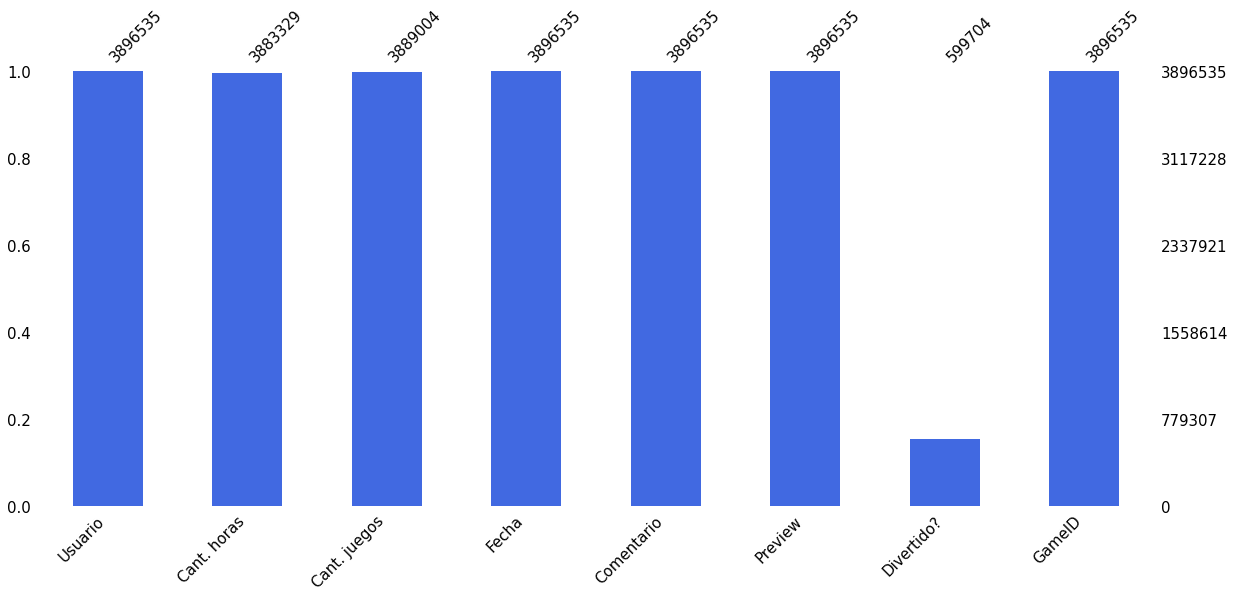

In [7]:
column = ''
for i in reviews.columns:
    if reviews[i].isna().sum() > 0:
        #isna_count = properati[i].isna().sum()
        cantidad = reviews[i].isna().sum()
        total = len(reviews)
        porcentaje = round(100*cantidad/total, 2)
        column += f'\t{ i } tiene { reviews[i].isna().sum() } datos nulos ({ porcentaje }%).\n'
print('Las siguientes columnas tienen valores nulos:')
print(column)

msno.bar(reviews, figsize=(20,8), fontsize=15, color='Royalblue')
plt.show()

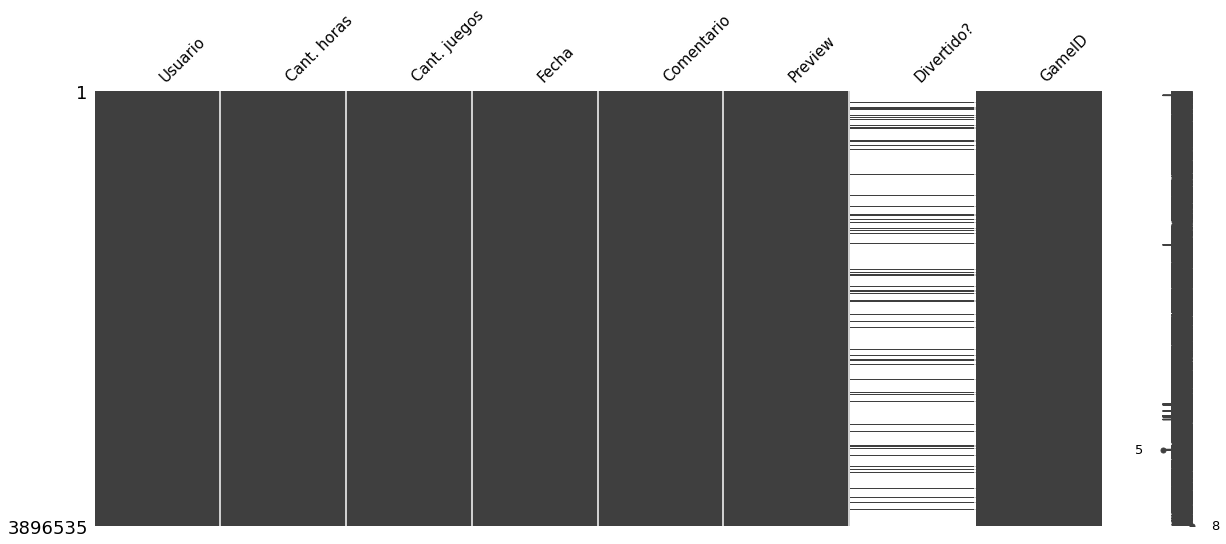

In [11]:
msno.matrix(reviews, figsize=(20,8), fontsize=15)
plt.show()

Como se puede observar, existen valores nulos en nuestro dataset. Se destaca la proporción de datos nulos que tiene el atributo `Divertido?`, más del 80% está incompleto y es la valoración que tienen los usuario sobre el juego luego de haber pasado x cantidad de horas jugando en el mismo.

Debido a la cantidad de datos nulos en dicho atributo, procedemos a eliminar el mismo.

In [12]:
reviews.drop(columns='Divertido?', inplace=True)

### Games

Finalizado este primer acercamiento con el dataset de críticas, importamos nuestros datos que contienen información sobre los juegos.

In [5]:
data_games = []
games_dir = '..\Proyecto III\steam_games.json.gz'
for games in parse(games_dir):
    data_games.append(games)
#games = pd.read_json(games_dir, compression='gzip', lines=False, orient='split', typ='series')

Analizamos el dataset de videojuegos, mostramos cinco registros al azar.

In [6]:
# Seleccionamos algunas columnas para mejorar los tiempos de procesamiento
columns = [ 'id', 'app_name', 'developer', 'title', 'release_date', 'genres', 'specs', 'tags', 'url', 'early_access', 'price', 'sentiment' ]
games = pd.DataFrame(data_games, columns=columns)
mapper = { 'id': 'GameID', 'app_name': 'Aplicación', 'developer': 'Desarrollador', 'release_date': 'Fecha lanzamiento', 'genres': 'Géneros',
           'specs': 'Especificaciones', 'tags': 'Etiquetas', 'url': 'Url', 'early_access': 'Acceso previo', 'price': 'Precio',
           'sentiment': 'Sentimiento' }
games.rename(columns=mapper, inplace=True)
games = games.reindex(columns=[ 'GameID', 'Aplicación', 'Desarrollador', 'Fecha lanzamiento', 'Géneros', 'Especificaciones', 'Etiquetas', 'Url',
                                'Acceso previo', 'Precio', 'Sentimiento' ])
del data_games

In [14]:
games = pd.DataFrame(data_games)
del data_games
games.sample(5)

,publisher,genres,app_name,title,url,release_date,tags,discount_price,reviews_url,specs,price,early_access,id,developer,sentiment,metascore
6977,NaN,[Indie],Just Bones - Just Bonus Track,Just Bones - Just Bonus Track,http://store.steampowered.com/app/515990/Just_...,2016-08-17,[Indie],NaN,http://steamcommunity.com/app/515990/reviews/?...,"[Single-player, Downloadable Content, Steam Ac...",Free,False,515990,Elephant Games,NaN,NaN
12310,Salus Games,"[Casual, Indie]",Layers,Layers,http://store.steampowered.com/app/661330/Layers/,2017-11-13,"[Indie, Casual, Singleplayer, Puzzle, Puzzle-P...",NaN,http://steamcommunity.com/app/661330/reviews/?...,"[Single-player, Steam Achievements, Steam Work...",0.99,False,661330,Salus Games,NaN,NaN
32097,Lunar Giant Studios,"[Action, Indie]",Tetrapulse,Tetrapulse,http://store.steampowered.com/app/250440/Tetra...,2016,"[Indie, Action, Co-op]",NaN,http://steamcommunity.com/app/250440/reviews/?...,"[Multi-player, Co-op, Shared/Split Screen, Ste...",NaN,False,250440,The Amiable,NaN,NaN
2246,Libredia,[Racing],HTR+ Slot Car Simulation,HTR+ Slot Car Simulation,http://store.steampowered.com/app/288650/HTR_S...,2014-05-29,"[Racing, Simulation]",NaN,http://steamcommunity.com/app/288650/reviews/?...,"[Single-player, Partial Controller Support]",6.99,False,288650,QUByte Interactive,Mostly Positive,NaN
16084,Vagabond Dog,"[Casual, Indie, Sports]",DOG GONE GOLFING,DOG GONE GOLFING,http://store.steampowered.com/app/665590/DOG_G...,2017-08-25,"[Sports, Casual, Indie, Pixel Graphics]",NaN,http://steamcommunity.com/app/665590/reviews/?...,"[Single-player, Local Multi-Player, Shared/Spl...",1.99,False,665590,Vagabond Dog,1 user reviews,NaN


Visualizamos un resumen de nuestro dataset.

In [12]:
print(f'Shape: { games.shape }')
games.info()

Shape: (32135, 16)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32135 entries, 0 to 32134
Data columns (total 16 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   publisher       24083 non-null  object 
 1   genres          28852 non-null  object 
 2   app_name        32133 non-null  object 
 3   title           30085 non-null  object 
 4   url             32135 non-null  object 
 5   release_date    30068 non-null  object 
 6   tags            31972 non-null  object 
 7   discount_price  225 non-null    float64
 8   reviews_url     32133 non-null  object 
 9   specs           31465 non-null  object 
 10  price           30758 non-null  object 
 11  early_access    32135 non-null  bool   
 12  id              32133 non-null  object 
 13  developer       28836 non-null  object 
 14  sentiment       24953 non-null  object 
 15  metascore       2677 non-null   object 
dtypes: bool(1), float64(1), object(14)
memory usage: 3.7+ MB


En este dataset contamos con 32.135 registros junto a 16 columnas. Visualizamos las distintas columnas y extraemos las más importantes para nuestro análisis.

In [152]:
column = '\t | '
for name in games.columns:
    column += f'{ name } | '
print('Los nombres de columnas del dataset son:')
print(column)

Los nombres de columnas del dataset son:
	 | publisher | genres | app_name | title | url | release_date | tags | discount_price | reviews_url | specs | price | early_access | id | developer | sentiment | metascore | 


In [15]:
games.drop(columns=[ 'discount_price', 'publisher', 'reviews_url', 'title' ], inplace=True)
mapper = { 'id': 'GameID', 'app_name': 'Aplicación', 'developer': 'Desarrollador', 'release_date': 'Fecha lanzamiento', 'genres': 'Géneros',
           'specs': 'Especificaciones', 'tags': 'Etiquetas', 'url': 'Url', 'early_access': 'Acceso previo', 'price': 'Precio',
           'sentiment': 'Sentimiento', 'metascore': 'Metascore' }
games.rename(columns=mapper, inplace=True)
games = games.reindex(columns=[ 'GameID', 'Aplicación', 'Desarrollador', 'Fecha lanzamiento', 'Géneros', 'Especificaciones', 'Etiquetas',
                                'Url', 'Acceso previo', 'Precio', 'Sentimiento', 'Metascore' ])
games.head()

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
0,761140,Lost Summoner Kitty,Kotoshiro,2018-01-04,"[Action, Casual, Indie, Simulation, Strategy]",[Single-player],"[Strategy, Action, Indie, Casual, Simulation]",http://store.steampowered.com/app/761140/Lost_...,False,4.99,NaN,NaN
1,643980,Ironbound,Secret Level SRL,2018-01-04,"[Free to Play, Indie, RPG, Strategy]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Strategy, Indie, RPG, Card Game...",http://store.steampowered.com/app/643980/Ironb...,False,Free To Play,Mostly Positive,NaN
2,670290,Real Pool 3D - Poolians,Poolians.com,2017-07-24,"[Casual, Free to Play, Indie, Simulation, Sports]","[Single-player, Multi-player, Online Multi-Pla...","[Free to Play, Simulation, Sports, Casual, Ind...",http://store.steampowered.com/app/670290/Real_...,False,Free to Play,Mostly Positive,NaN
3,767400,弹炸人2222,彼岸领域,2017-12-07,"[Action, Adventure, Casual]",[Single-player],"[Action, Adventure, Casual]",http://store.steampowered.com/app/767400/2222/,False,0.99,NaN,NaN
4,773570,Log Challenge,NaN,NaN,NaN,"[Single-player, Full controller support, HTC V...","[Action, Indie, Casual, Sports]",http://store.steampowered.com/app/773570/Log_C...,False,2.99,NaN,NaN


Luego de descartar las columnas que no nos sirven, analizamos los valores nulos.

Las siguientes columnas tienen valores nulos:
	GameID tiene 2 datos nulos (0.01%).
	Aplicación tiene 2 datos nulos (0.01%).
	Desarrollador tiene 3299 datos nulos (10.27%).
	Fecha lanzamiento tiene 2067 datos nulos (6.43%).
	Géneros tiene 3283 datos nulos (10.22%).
	Especificaciones tiene 670 datos nulos (2.08%).
	Etiquetas tiene 163 datos nulos (0.51%).
	Precio tiene 1377 datos nulos (4.29%).
	Sentimiento tiene 7182 datos nulos (22.35%).
	Metascore tiene 29458 datos nulos (91.67%).



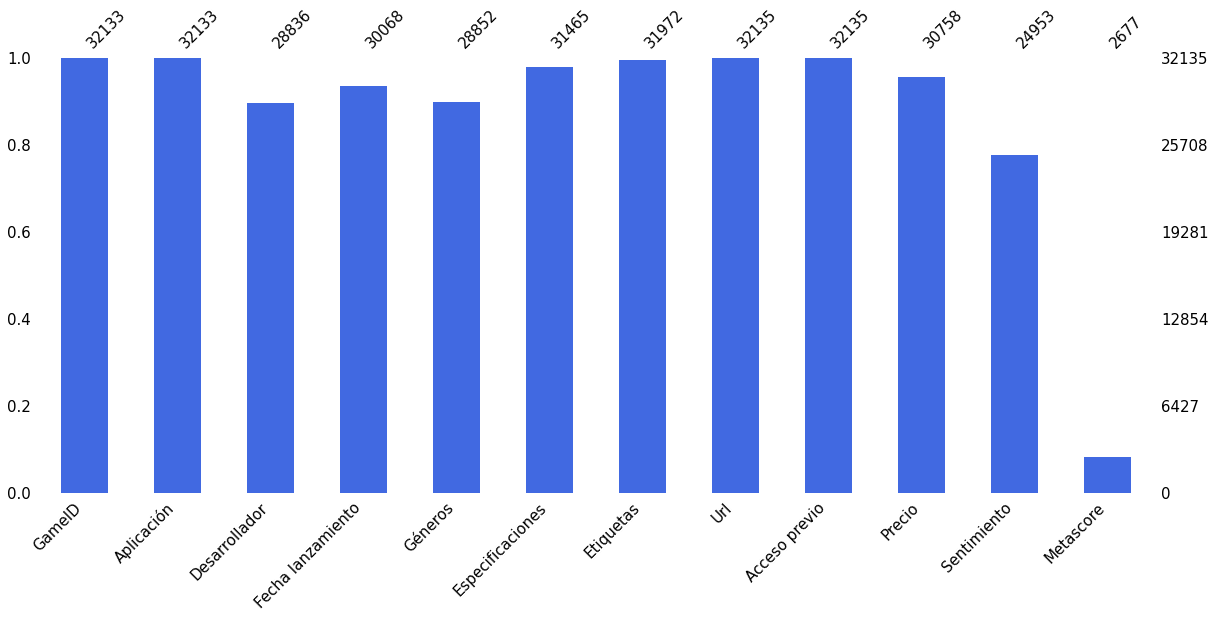

In [16]:
column = ''
for i in games.columns:
    if games[i].isna().sum() > 0:
        #isna_count = properati[i].isna().sum()
        cantidad = games[i].isna().sum()
        total = len(games)
        porcentaje = round(cantidad*100/total, 2)
        column += f'\t{ i } tiene { games[i].isna().sum() } datos nulos ({ porcentaje }%).\n'
print('Las siguientes columnas tienen valores nulos:')
print(column)

msno.bar(games, figsize=(20,8), fontsize=15, color='Royalblue')
plt.show()

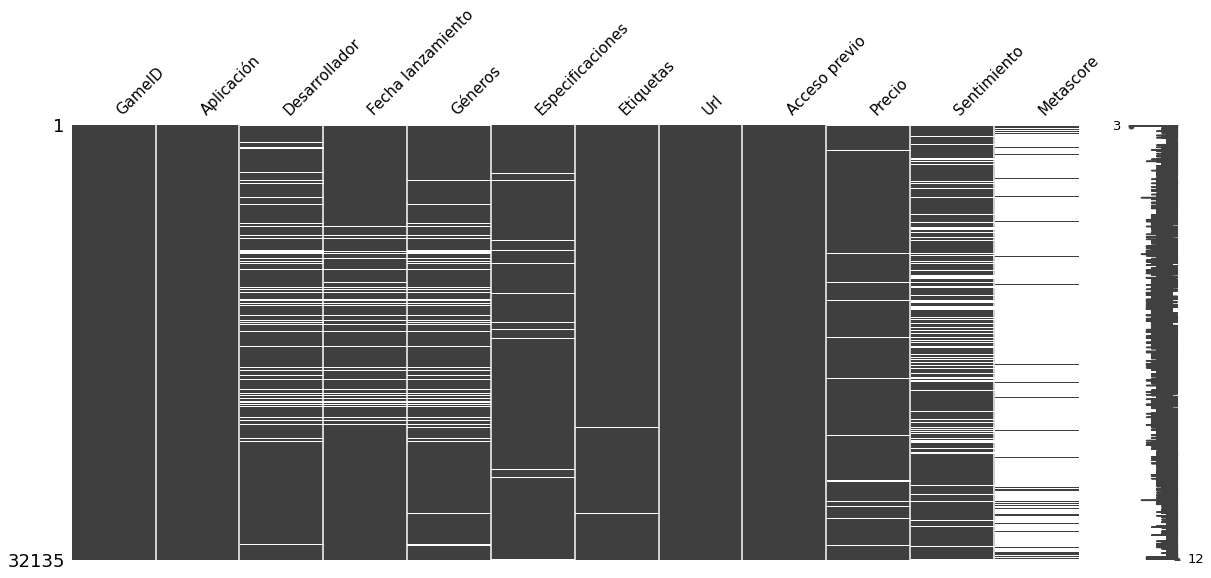

In [17]:
msno.matrix(games, figsize=(20,8), fontsize=15)
plt.show()

Como se puede observar, existe mucha presencia de valores faltantes. El atributo ```Metascore``` tiene más del 90% de los registros como valores nulos y el atributo ```Sentimiento``` posee más del 20%.

In [18]:
games.drop(columns='Metascore', inplace=True)

In [7]:
sns.set_style('whitegrid')

## **Preprocesamiento**

El dataset correspondiente a la información de los videojuegos es el que necesita un preprocesamiento en los datos y el dataset de los comentarios no presenta mayores problemas. De todos modos se hacen algunos ajustes en el mismo.

### Reviews

#### Duplicados

En esta sección vamos a analizar tanto la presencia de registros duplicados como la presencia de varios comentarios (más de uno) que un mismo usuario realiza sobre un juego. En primer lugar, buscamos los registros duplicados y analizamos los mismos.

In [15]:
mask = reviews.duplicated()
reviews[mask].sample(5)

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
3267525,Xyvos,0.4,44.0,2014-07-09,Terrible...But I still love it.\n10/10,False,221640
1546228,nrrdy,14.1,54.0,2015-06-17,The best game I ever played!,False,620
3185154,Lamanunez,18.3,32.0,2017-03-06,Bought the game casue it was on sale and thoug...,False,213670
123006,Biebersan,279.1,86.0,2017-09-04,"Shiiiiiiieeeet negro, best game ever.",False,48700
919305,Hypersomnia,6.6,38.0,2017-01-02,"Playing Bastion is one hell of a ride.\nSo, wh...",False,107100


In [16]:
print(f'Existen { reviews[mask].shape[0] } registros duplicados.')

Existen 215303 registros duplicados.


Como se puede observar, existen **215.303 datos duplicados** en nuestro dataset. Investigamos un usuario al azar.

In [17]:
name = 'Kabuto'
reviews.query('Usuario == @name')

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
2458289,Kabuto,27.3,260.0,2017-09-12,"Very fun game, good variety of characters all ...",False,402570
3433850,Kabuto,28.3,32.0,2015-09-09,Best COD ever created,False,10180
3433938,Kabuto,28.3,32.0,2015-09-09,Best COD ever created,False,10180


Como se observa, existen *dos comentarios que realizó el usuario **Kabuto** sobre el juego 10.180*, también se verifica que la fecha como el comentario realizado es el mismo. Eliminamos los duplicados y vemos cantidad de usuarios y de juegos a analizados.

In [8]:
reviews.drop_duplicates(inplace=True)
print('Registros finales:', reviews.shape[0])
print('Total de juegos:', games.GameID.value_counts().count())
print('Total de juegos con comentarios:', reviews.GameID.value_counts().count())
print('Total de usuarios:', reviews.Usuario.value_counts().count())

Registros finales: 3681232
Total de juegos: 32132
Total de juegos con comentarios: 14970
Total de usuarios: 1716724


---
COMENTARIOS DUPLICADOS

---

Como se observó previamente, existían registros duplicados. Si realizamos la misma búsqueda de registros duplicados, pero, solamente teniendo en cuenta los usuarios y el juego, nos vamos a encontrar con lo siguiente:

In [19]:
mask = reviews.duplicated(subset=['Usuario', 'GameID', 'Preview'])
print(f'Existen { reviews[mask].shape[0] } comentarios que un usuario realizó en un mismo videojuego.')
reviews[mask].sample(5)

Existen 25554 comentarios que un usuario realizó en un mismo videojuego.


,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
886917,Ghost,56.0,133.0,2014-12-18,8.5/10 good game. worth for what i paid,False,235600
3671037,Joe,13.3,1142.0,2014-06-15,"This game is fantastic. It's slick, stylish an...",False,220440
99899,Tom,57.2,53.0,2017-06-26,"I bought a PC so I could play GTA V with mods,...",False,271590
678388,Andrew,48.8,47.0,2014-10-14,i got the techdemo of this gmae and played it ...,False,263280
723783,V1P3R,2.2,20.0,2017-12-22,Civ 5 was better. Way to downgrade.,False,289070


Tomamos un usuario al azar y corroboramos que el mismo usuario comento más de una vece un videojuego.

In [20]:
name = 'Ori'
reviews.query('Usuario == @name & GameID == "261570"')

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
1219825,Ori,15.2,40.0,2016-12-02,best game i habe played .,False,261570
1279710,Ori,12.6,151.0,2015-06-25,Best 2D Jump n Run Game. Period!\n!!!!! Forlor...,False,261570


En estos casos, la metodología que se eligió fue eliminar aquellos comentarios que sean más antiguos, de este modo, nos quedamos con el último comentario realizado por el usuario, osea, nos quedamos con la última impresión del usuario sobre el juego.

In [9]:
reviews = reviews.sort_values(by='Fecha', ascending=False).drop_duplicates(subset=['Usuario', 'GameID'])

Verificamos el resultado con el usuario **Ori** y el mismo juego **261.570**.

In [11]:
name = 'Ori'
reviews.query('Usuario ==  @name & GameID == "261570"')

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
1219825,Ori,15.2,40.0,2016-12-02,best game i habe played .,False,261570


Finalmente, visualizamos la cantidad de registros.

In [23]:
print('Registros finales:', reviews.shape[0])

Registros finales: 3654720


#### Valores faltantes

Respecto a los valores faltantes de nuestro dataset correspondiente a las críticas, se procede directamente a la eliminación de aquellos registros nulos. 

De un universo de 3.896.535 registros, sólo 20.737 tienen valores faltantes entre las columnas `Cant. horas` y `Cant. juegos`; la eliminación de los mismos no implica una pérdida de datos significativa. 

In [24]:
prueba = reviews.copy()
prueba.isna().sum()

Usuario             0
Cant. horas     13018
Cant. juegos     7113
Fecha               0
Comentario          0
Preview             0
GameID              0
dtype: int64

Una solución para abordar el problema de valores faltantes podría ser el relleno de los mismos con el promedio de horas jugadas. Podríamos hacer algo así:

In [25]:
prueba['Cant. horas'].fillna(prueba.groupby('Usuario')['Cant. horas'].transform('mean'), inplace=True)

De todos modos, podemos observar que no se realizaron algunas imputaciones.

In [26]:
prueba.query('`Cant. horas`.isna()', engine='python').sample(5)

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
2264398,pray # laleagane.ro,NaN,171.0,2015-06-26,Foarte interesant !\nMultumesc,False,380890
2923126,Darkghost154,NaN,155.0,2015-05-28,Most epic movie ever,False,374570
425721,SNTRY [IM9],NaN,84.0,2016-05-30,"Its good, really good. Don't approach it like ...",False,353370
424682,jut1988,NaN,137.0,2016-06-02,There is a bit of a learning curve but once yo...,False,353370
432181,seventhfloor,NaN,96.0,2016-04-01,The learning/familiarity curve does exist (eve...,False,353370


In [27]:
prueba.loc[3586231, :]

Usuario           [bic]CaptainMiller
Cant. horas                      NaN
Cant. juegos                   202.0
Fecha                     2011-02-12
Comentario      Direct-Tank-Control!
Preview                        False
GameID                         20540
Name: 3586231, dtype: object

Investigamos un usuario al azar para ver que ocurre.

In [29]:
username = 'n4p4l44'
prueba.query('Usuario == @username')

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
385594,n4p4l44,NaN,38.0,2018-01-05,I chose to buy the Steam Controller over an XB...,False,353370


Como se puede observar, este usuario solamente hizo un solo comentario de un juego y ningún comentario más. Por lo tanto, no obtenemos un promedio de horas. En estos casos, rellenamos con el promedio de horas que tiene el juego.

In [30]:
prueba['Cant. horas'].fillna(prueba.groupby('GameID')['Cant. horas'].transform('mean'), inplace=True)
prueba.isna().sum()

Usuario            0
Cant. horas        7
Cant. juegos    7113
Fecha              0
Comentario         0
Preview            0
GameID             0
dtype: int64

Solamente nos quedaron 7 registros sin poder completar.

In [31]:
prueba[prueba['Cant. horas'].isna()]

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
3087215,yannick034,NaN,70.0,2017-12-31,How do we use it,False,666200
287111,OGK_Demipimp,NaN,109.0,2017-12-18,Its a text file in your gamefolder I like to t...,False,538610
531091,tinaellie2,NaN,163.0,2017-11-08,Yikes...This game has issues. Not just glitche...,False,436430
1819096,Celtic Dragon,NaN,9.0,2017-06-23,Now without the rule of three I think this is ...,False,545740
1425747,Beil Bostoob,NaN,543.0,2016-05-31,This soundtrack changed my life 10/10,False,407400
1353961,String_Relativity,NaN,15.0,2016-05-05,"5 Bosses and 52 new levels. Now costs $5, but ...",False,461200
2363403,DamagedYT,NaN,34.0,2015-12-18,I cant Actually Run this Like i have the Files...,False,419640


Estos corresponden a juegos donde solo tenemos un comentario los cuales corresponde a usuarios sin horas registradas.

In [32]:
prueba.query('GameID == "666200"')

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID
3087215,yannick034,NaN,70.0,2017-12-31,How do we use it,False,666200


Podemos proceder a eliminar dichos registros con datos faltantes y nos queda un dataset limpio de valores faltantes en nuestro atributo `Cant. horas`. El otro atributo que tiene valores faltantes nos puede servir para crear un rating propio, pero, nos vamos a centrar en un sistema de recomendación basado en ratings implicitos. Aquí, la cantidad de horas pasa a tener un papel ponderante ya que un usuario, luego de jugar un juego o utilizar un producto x horas, nos da una pauta de que tan interesante le resulta.

Como se mencionó al inicio de esta sección, eliminamos los valores faltantes de dichas columnas utilizando el método `dropna`.

In [10]:
#del prueba
reviews.dropna(subset=['Cant. horas', 'Cant. juegos'], inplace=True)

#### Varios

En esta sección se pretende emendar “errores” varios que se van encontrando en el dataset correspondiente a los comentarios.

Como punto de partida, encontramos en nuestros registros datos de los usuarios que inducen al error. Como nombre de `Usuario` encontramos lo siguiente:

In [42]:
reviews[reviews.Usuario.str.contains('[^\u0001-\u007F]{3,}')]

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,GameID
946318,✦Димитрис✦,1.6,66.0,2018-01-05,"Fun game, wierdly addictive, would reccomend",217100
1580378,空白《叶秋》,254.0,19.0,2018-01-05,Very fun XD lmao,359550
2115050,ШопскиСРБ,41.8,44.0,2018-01-05,Great survival game with good story !The game ...,242760
2435781,ℳ𝓻.𝓦𝓸𝓵𝒇𝓲𝒆,115.7,131.0,2018-01-05,"If you don't enjoy farming/grinding, this is n...",230410
2435697,Неки лик,17.2,8.0,2018-01-05,"Tried to play 5 times, still cant get the feel...",230410
...,...,...,...,...,...,...
604632,Cyriel ᛭ᚲᛃᚱᛁᛖᛚ᛭,6.6,825.0,2010-11-02,Hell yes people. Just yes.,39800
799498,Вежливый из Крыма (РФ),0.1,374.0,2010-11-01,That's an awesome game! Must Have! Played in 2...,11480
3400467,Белый охотник,32.3,109.0,2010-10-17,i just love it!,630
2933762,ﾚ҉.̠̪͎̯̮ͤ͛̋̀͆ͮ̐7,0.9,730.0,2010-10-17,Oddly entertaining.,11370


Cómo se observa, existen carácteres especiales en los nombres de los usuarios. También nos enontramos con la misma situación en los comentarios. Analizamos que sucede con aquellos registros que tiene como nombre de usuario la palabra **null**.

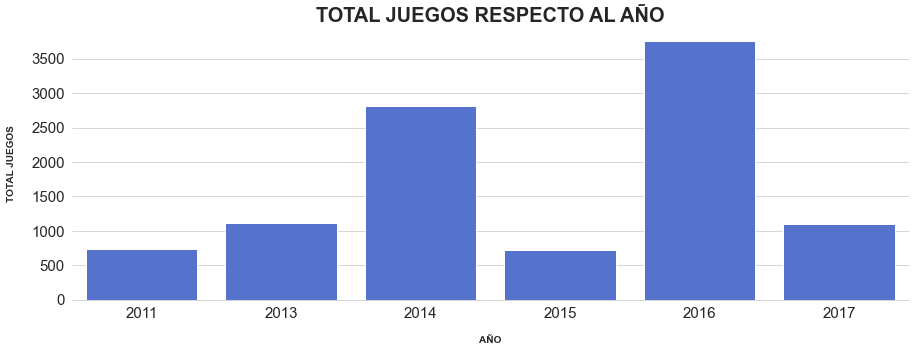

In [12]:
data = reviews.query('Usuario == "null"').loc[:,('Usuario', 'Cant. juegos', 'Fecha')].sort_values(by='Fecha', ascending=True)
data['Fecha'] = pd.to_datetime(data['Fecha'])
data['Año'] = data['Fecha'].dt.year

data = data.groupby(by=['Año']).aggregate({'Cant. juegos': sum})

plt.figure(figsize=(15,5))
sns.barplot(x=data.index, y='Cant. juegos', data=data, color='Royalblue')
plt.title('Total juegos respecto al año'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Año'.upper(), fontsize=10, labelpad=15, weight='bold')
plt.ylabel('Total juegos'.upper(), fontsize=10, labelpad=15, weight='bold')
sns.despine(left=True)
plt.show()

Si tomamos *null* como el nombre de usuario podemos ver como el total de juegos varía año a año. Estos datos inducen al error ya que podemos observar como la cantidad de juegos que se adquirio debería ser constante de forma ascendente.

Este caso puede ser un usuario que eligió null como su nombre de usuario o hubo un inconveniente al momento de capturar el dato cuando se realizó el *web scrapping*.

In [11]:
idx = reviews.query('Usuario == "null"').index
reviews.drop(idx, inplace=True)

Respecto a estos casos, eliminamos los registros ya que es imposible identificar los usuarios a los que corresponden cada registro.

In [12]:
reviews['Usuario'] = reviews['Usuario'].astype('string')
reviews['Cant. horas'] = reviews['Cant. horas'].astype('float32')
reviews['Cant. juegos'] = reviews['Cant. juegos'].astype('float32')
reviews['Fecha'] = pd.to_datetime(reviews['Fecha'])
reviews['Comentario'] = reviews['Comentario'].astype('string')
reviews['Preview'] = reviews['Preview'].astype('category')
reviews['GameID'] = reviews['GameID'].astype('int32')
reviews.reset_index(drop=True, inplace=True)
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3634562 entries, 0 to 3634561
Data columns (total 7 columns):
 #   Column        Dtype         
---  ------        -----         
 0   Usuario       string        
 1   Cant. horas   float32       
 2   Cant. juegos  float32       
 3   Fecha         datetime64[ns]
 4   Comentario    string        
 5   Preview       category      
 6   GameID        int32         
dtypes: category(1), datetime64[ns](1), float32(2), int32(1), string(2)
memory usage: 128.2 MB


###  Games

#### Duplicados

Empezamos con este análisis preliminar de duplicados buscando valores que se repitan a groso modo. Más adelante entraremos en un detalle realizando un análisis más profundo.

In [157]:
duplicados = len(games[games.drop(columns=['Especificaciones', 'Etiquetas','Géneros']).duplicated()])
print(f'Total de registros duplicados: {duplicados}')

Total de registros duplicados: 0


En está primer acercamiento, parece ser que no existen registros duplicados. Si analizamos las columnas que conforman dicho dataset nos encontramos que contamos con campos en los cuales difícilmente sean similares con otros registros. Por ejemplo, el atributo `GameID` es identificador único entre los distintos registros, a su vez, este mismo campo tiene influencia en el atributo `Url` ya que en la misma podemos encontrar dicho valor.

In [158]:
games.loc[1068, ['GameID', 'Aplicación', 'Url']]

GameID                                                   200260
Aplicación       Batman: Arkham City - Game of the Year Edition
Url           http://store.steampowered.com/app/200260/Batma...
Name: 1068, dtype: object

Como se puede verificar, en el campo *Url* se encuentra el GameID del juego. Si elegimos incorrectamente las columnas no vamos a encontrar registros duplicados. En este caso, se van a elegir los siguientes atributos: `Aplicación`, `Desarrollador`.

In [184]:
games[games.loc[:,['Aplicación', 'Desarrollador']].duplicated(keep=False)]

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
74,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,http://store.steampowered.com/,False,19.99,NaN,NaN
1068,200260,Batman: Arkham City - Game of the Year Edition,"Rocksteady Studios,Feral Interactive (Mac)",2012-09-07,"[Action, Adventure]","[Single-player, Steam Achievements, Steam Trad...","[Action, Open World, Batman, Adventure, Stealt...",http://store.steampowered.com/app/200260/Batma...,False,19.99,Overwhelmingly Positive,91
1508,93304,The Dream Machine: Chapter 4,Cockroach Inc.,2013-08-05,"[Adventure, Casual, Indie]","[Single-player, Downloadable Content, Steam Tr...","[Indie, Adventure, Casual, Great Soundtrack, S...",http://store.steampowered.com/app/93304/The_Dr...,False,4.99,NaN,NaN
1509,94304,The Dream Machine: Chapter 4,Cockroach Inc.,2013-08-05,"[Adventure, Casual, Indie]","[Single-player, Downloadable Content, Steam Tr...","[Adventure, Indie, Casual]",http://store.steampowered.com/app/94304/The_Dr...,False,NaN,NaN,NaN
2580,317160,<NA>,<NA>,2014-08-26,"[Action, Indie]","[Single-player, Game demo]","[Action, Indie]",http://store.steampowered.com/app/317160/_/,False,NaN,Positive,NaN
4440,401200,Invisible Apartment 2,"Milan Kazarka,Jeroen van Oosten",2015-09-24,"[Adventure, Indie]",[Single-player],"[Adventure, Indie, Visual Novel, Anime, Hackin...",http://store.steampowered.com/app/401200/Invis...,False,7.99,4 user reviews,NaN
8117,529700,Total Extreme Wrestling,Grey Dog Software,2016-12-02,[Sports],[Single-player],"[Sports, Wrestling, Management]",http://store.steampowered.com/app/529700/Total...,False,19.99,Positive,NaN
10350,654070,Escape Room,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Adventure, VR]",http://store.steampowered.com/app/654070/Escap...,False,0.99,7 user reviews,NaN
13155,773080,MORE SWEATER? OK!,Triple-Star Studio,2017-12-19,"[Casual, Indie, Simulation]","[Single-player, Downloadable Content, Steam Ac...","[Indie, Casual, Simulation]",http://store.steampowered.com/app/773080/MORE_...,False,0.99,NaN,NaN
13421,758210,Escape Room,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Early Access, Adventure, Simulation, VR]",http://store.steampowered.com/app/758210/Escap...,True,Free,Mostly Negative,NaN


Como podemos visualizar, existen varios registros duplicados. En algunos de ellos se repite el atributo `GameID`, en otros no pero varian los campos de otras columnas; también, nos encontramos con juegos donde la *fecha de lanzamiento* y el *nombre de la aplicación* del son equivalentes.

Sí nos basamos únicamente en el nombre vamos a encontrar muchos juegos con el mismo nombre pero distinto desarrollador. Sí buscamos juegos con el mismo nombre, el mismo desarrollador y la misma fecha de lanzamiento nos vamos a encontrar con algunos registros donde el nombre del desarrollador es distinto.

De acuerdo a la selección de columnas varían los duplicamos. Lo vemos a continuación:

In [160]:
print(f'Existen {len(games[games["Aplicación"].duplicated()])} juegos duplicados por nombre.')
print(f'Existen {len(games[games[["Aplicación", "Desarrollador"]].duplicated()])} juegos duplicados por nombre y desarrollador.')
print(f'Existen {len(games[games[["Aplicación", "Desarrollador", "Fecha lanzamiento"]].duplicated()])} juegos duplicados por nombre, desarrollador y fecha.')

Existen 40 juegos duplicados por nombre.
Existen 9 juegos duplicados por nombre y desarrollador.
Existen 5 juegos duplicados por nombre, desarrollador y fecha.


Nos vamos a centrar en aquellos registros duplicados donde comparten el **nombre** y la **fecha de lanzamiento**.

In [161]:
games[games[['Aplicación', 'Fecha lanzamiento']].duplicated(keep=False)]

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
1068,200260,Batman: Arkham City - Game of the Year Edition,"Rocksteady Studios,Feral Interactive (Mac)",2012-09-07,"[Action, Adventure]","[Single-player, Steam Achievements, Steam Trad...","[Action, Open World, Batman, Adventure, Stealt...",http://store.steampowered.com/app/200260/Batma...,False,19.99,Overwhelmingly Positive,91
1508,93304,The Dream Machine: Chapter 4,Cockroach Inc.,2013-08-05,"[Adventure, Casual, Indie]","[Single-player, Downloadable Content, Steam Tr...","[Indie, Adventure, Casual, Great Soundtrack, S...",http://store.steampowered.com/app/93304/The_Dr...,False,4.99,NaN,NaN
1509,94304,The Dream Machine: Chapter 4,Cockroach Inc.,2013-08-05,"[Adventure, Casual, Indie]","[Single-player, Downloadable Content, Steam Tr...","[Adventure, Indie, Casual]",http://store.steampowered.com/app/94304/The_Dr...,False,NaN,NaN,NaN
10350,654070,Escape Room,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Adventure, VR]",http://store.steampowered.com/app/654070/Escap...,False,0.99,7 user reviews,NaN
13421,758210,Escape Room,<NA>,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Early Access, Adventure, Simulation, VR]",http://store.steampowered.com/app/758210/Escap...,True,Free,Mostly Negative,NaN
13894,612880,Wolfenstein II: The New Colossus,Machine Games,2017-10-26,[Action],"[Single-player, Steam Achievements, Full contr...","[Action, FPS, Gore, Violent, Alternate History...",http://store.steampowered.com/app/612880/,False,59.99,Mostly Positive,86
14573,612880,Wolfenstein II: The New Colossus,Machine Games,2017-10-26,[Action],"[Single-player, Steam Achievements, Full contr...","[Action, FPS, Gore, Violent, Alternate History...",http://store.steampowered.com/app/612880/Wolfe...,False,59.99,Mostly Positive,86
27671,329270,Warhammer Quest,"Twistplay,Rodeo Games",2015-01-07,"[RPG, Strategy]","[Single-player, Downloadable Content, Steam Ac...","[Strategy, RPG]",http://store.steampowered.com/app/329270/Warha...,False,NaN,9 user reviews,55
27672,326670,Warhammer Quest,"Rodeo Games,Twistplay",2015-01-07,"[RPG, Strategy]","[Single-player, Steam Achievements, Steam Trad...","[RPG, Strategy, Games Workshop, Turn-Based, Bo...",http://store.steampowered.com/app/326670/Warha...,False,14.99,Mixed,55
30178,224850,Aliens: Colonial Marines - Reconnaissance Pack,Gearbox Software,2013-05-07,[Action],"[Single-player, Multi-player, Co-op, Downloada...",[Action],http://store.steampowered.com/app/224850/Alien...,False,NaN,NaN,NaN


Al ser pocos registros, se realizo una búsqueda por internet sobre los distintos registros y se encontró lo siguiente:

* **Aliens: Colonial Marines - Reconnaissance Pack**: Mismo artículo, url indica diferencia según país.
* **Batman: Arkham City - Game of the Year Edition**: Mismo artículo, solo uno tiene `GameID`, se verifica en la url que es la misma en los dos registros.
* **Escape room**: Son dos juegos distintos.
* **The Dream Machine: Chapter 4**: El válido corresponde al siguiente `GameID`: 94.304.
* **Warhammer Quest**: Uno corresponde a un juego y el otro a DLC (mismo árticulo, el campo desarrollador difiere).
* **Wolfenstein II: The New Colossus**: Difiere la `Url` pero corresponden al mismo juego.

Al ser pocos juegos duplicados sin posibilidad de filtrar el correcto se hace una eliminación manual. Los siguientes registros se eliminan: 30961, 30178, 13894, 1508.

In [13]:
games.drop([30961, 30178, 13894, 1508], axis=0, inplace=True)
games[games[['Aplicación', 'Fecha lanzamiento']].duplicated(keep=False)]

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento
10350,654070,Escape Room,NaN,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Adventure, VR]",http://store.steampowered.com/app/654070/Escap...,False,0.99,7 user reviews
13421,758210,Escape Room,NaN,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Early Access, Adventure, Simulation, VR]",http://store.steampowered.com/app/758210/Escap...,True,Free,Mostly Negative
27671,329270,Warhammer Quest,"Twistplay,Rodeo Games",2015-01-07,"[RPG, Strategy]","[Single-player, Downloadable Content, Steam Ac...","[Strategy, RPG]",http://store.steampowered.com/app/329270/Warha...,False,NaN,9 user reviews
27672,326670,Warhammer Quest,"Rodeo Games,Twistplay",2015-01-07,"[RPG, Strategy]","[Single-player, Steam Achievements, Steam Trad...","[RPG, Strategy, Games Workshop, Turn-Based, Bo...",http://store.steampowered.com/app/326670/Warha...,False,14.99,Mixed


A estos registros se los corrige para que sean acordes a la información que se extrae de la plataforma steam.

In [14]:
# Escape Room
games.loc[10350,'Desarrollador'] = 'AppFactoryHaru-Ni'
games.loc[10350,'Fecha lanzamiento'] = '2017-06-30'

games.loc[13421,'Desarrollador'] = 'OneTechAsia'
games.loc[13421,'Fecha lanzamiento'] = '2017-12-11'
# Warhammer Quest
games.loc[27671,'Desarrollador'] = 'Rodeo Games,Twistplay'

#### Valores faltantes

> **ACLARACIÓN**:
Descartamos del análisis las columnas `Desarrollador`, `Fecha lanzamiento`, `Metascore`, y `Sentimiento` ya que son las que destacan en valores nulos y no considero relevante su uso al momento de realizar el sistema de recomendación. Si las etiquetas `Metascore`,  y `Sentimiento` tuviesen más datos sería un aporte sideral para la finalidad de nuestro proyecto. Recordemos que **Metascore tiene 29458 datos nulos (91.67%)** y **Sentimiento** tiene 7182 datos nulos (22.35%).

Analizamos los valores nulos de nuestro dataset correspondiente a los juegos. Nos vamos a enfocar en los siguientes atributos: `GameID`, `Aplicación`, `Géneros`, `Especificaciones`, `Etiquetas`, `Precio`.

In [131]:
games.isna().sum()

GameID                  1
Aplicación              2
Desarrollador        3297
Fecha lanzamiento    2065
Géneros              3283
Especificaciones      670
Etiquetas             163
Url                     0
Acceso previo           0
Precio               1376
Sentimiento          7180
dtype: int64

---
**GameID y Aplicación**

---
Buscamos los nulos de `GameID` y `Aplicación` ya que ellas mismas nos ayudan a entender que juego estamos analizando a través del nombre y del identificador.

In [165]:
games.query('Aplicación.isna() | GameID.isna()', engine='python')

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
74,NaN,<NA>,<NA>,NaN,NaN,NaN,NaN,http://store.steampowered.com/,False,19.99,NaN,NaN
2580,317160,<NA>,<NA>,2014-08-26,"[Action, Indie]","[Single-player, Game demo]","[Action, Indie]",http://store.steampowered.com/app/317160/_/,False,NaN,Positive,NaN


Podemos corroborar que el registro 74 comparte nulidad en `GameID` y `Aplicación`. Prodecemos a eliminarlo y vamos a tratar de completar los datos faltantes de los otros registros. 

In [15]:
games.drop([74], axis=0, inplace=True)
games.query('Aplicación.isna() | GameID.isna()', engine='python')

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento
2580,317160,NaN,NaN,2014-08-26,"[Action, Indie]","[Single-player, Game demo]","[Action, Indie]",http://store.steampowered.com/app/317160/_/,False,NaN,Positive


Buscamos a través del atributo `Url` información oficial *—plataforma de steam—* sobre el nombre del juego o el id. La url de cada registro nos brinda información importante como vimos anteriormente, nos ayuda a completar los datos faltantes y buscar información sobre el registro para entender con que se está lidiando.

In [11]:
print(games.loc[2580,:].Url)

http://store.steampowered.com/app/317160/_/


De esta url no podemos inferir el nombre del juego, ingresando en la misma si podemos corroborar esto. El juego en cuestión es un demo llamado **Duet**. Tratamos de inspeccionar en la base de datos información sobre este juego.

In [18]:
app_name = "Duet"
games.query('Aplicación == @app_name')

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento
4103,292600,Duet,Kumobius,2015-08-03,"[Action, Indie]","[Single-player, Steam Achievements, Full contr...","[Indie, Action, Minimalist, Great Soundtrack, ...",http://store.steampowered.com/app/292600/Duet/,False,4.99,Very Positive


Como se puede ver, corresponde a otro registro duplicado. Antes de eliminarlo deberiamos corroborar que el mismo no tenga ninguna review, también se debería realizar lo mismo con los registros que se eliminaron previamente. Al ser un demo de otro juego, podriamos eliminarlo y cambiar los registros en nuestro dataset referido a los comentarios para que estos apunten al juego final.

Eliminamos el demo del juego.

In [16]:
games.drop([2580], axis=0, inplace=True)

Correciones en el dataset `Reviews`.

In [17]:
total = len(reviews.query('GameID == 317160')) + len(reviews.query('GameID == 224850')) + len(reviews.query('GameID == 612880')) +\
        len(reviews.query('GameID == 93304'))
print('Total de registros afectados: ' + str(total))

Total de registros afectados: 2998


El único registro que se ve afectado es el que corresponde al juego **Wolfenstein II: The New Colossus**, es un registro duplicado en el cuál solo difiere en la `Url`, como se mencionó.

---
**Géneros, etiquetas y especificaciones**

---


El desafío con el que nos encontramos es completar la mayor cantidad de datos faltantes que en la variable categórica `Géneros` y `Especificaciones`.

FUNCIÓN PARA GRÁFICAR LAS CATEGORÍAS

In [17]:
def get_data(category, data=games):
    data = data[category].dropna().to_numpy()
    unicos = []
    for items in data:
        if any(items):
            unicos.extend(items)
    values, count = np.unique(unicos, return_counts=True)
    return pd.DataFrame({category: values, 'cantidad': count}), values

def graficar_categorias(filter):
    fig, axs = plt.subplots(1, 3, figsize=(20,8), tight_layout=True, sharey=True)
    fig.suptitle(f'Análisis de las categorias'.upper(), fontsize=25, fontweight='semibold')
    
    categories = ['Géneros', 'Especificaciones', 'Etiquetas']
    for idx, label in enumerate(categories):
        data = get_data(label)[0]
        data = data.pivot_table(values='cantidad', index=label, aggfunc={'cantidad': lambda x: x*100/data['cantidad'].sum()})
        data = data.query(f'cantidad >= {filter}').reset_index()
        
        sns.barplot(x=label, y='cantidad', color='Royalblue', data=data, order=data.sort_values('cantidad', ascending=False)[label], saturation=1,
                    ax=axs[idx])
        axs[idx].set_title(f'{label}'.upper(), fontsize=20, weight='bold')
        axs[idx].set_xlabel('')
        axs[idx].set_ylabel('Porcentaje'.upper(), fontsize=12, labelpad=10, weight='bold')
        axs[idx].tick_params(axis='both', labelsize=15)
        axs[idx].tick_params(axis='x', rotation=90)
    sns.despine(left=True)
    plt.show()

FUNCIÓN PARA COMPLETAR LOS VALORES FALTANTES

In [18]:
def completar(data, target_column):
    # Creamos una lista para guardar los tags para luego analizarlos.
    nulos = []
    index = data.index
    # Generamos una lista de valores únicos que posee la columna que deseamos completar.
    values = get_data('Géneros')[1] if target_column == 'Géneros' else get_data('Especificaciones')[1]
    # Generamos una lista de valores únicos que posee la otra columna.
    other = get_data('Géneros')[1] if target_column == 'Géneros' else get_data('Especificaciones')[1]
    for idx in index:
        # Buscamos los tags de cada registro.
        tags = games.at[idx, 'Etiquetas']
        if any(tags):
            # Calculamos la intersection con la columna a rellenar.
            intersection = set.intersection(set(tags), set(values))
            if any(intersection):
                # Guardamos los datos en el registro.
                games.at[idx, target_column] = list(intersection) 
            else:
                # Sino hay nada dejamos como null.
                games.at[idx, target_column] = np.nan
                # Guardamos los datos de tags que no pertenecen a la otra columna.
                nulos.extend(list(set(tags) - set(other)))
        else:
            print('Tags is null')
    return nulos

Antes de hacer un cualquier tarea, necesitamos hacer un análisis preliminar de los datos que contienen nuestras categorías.

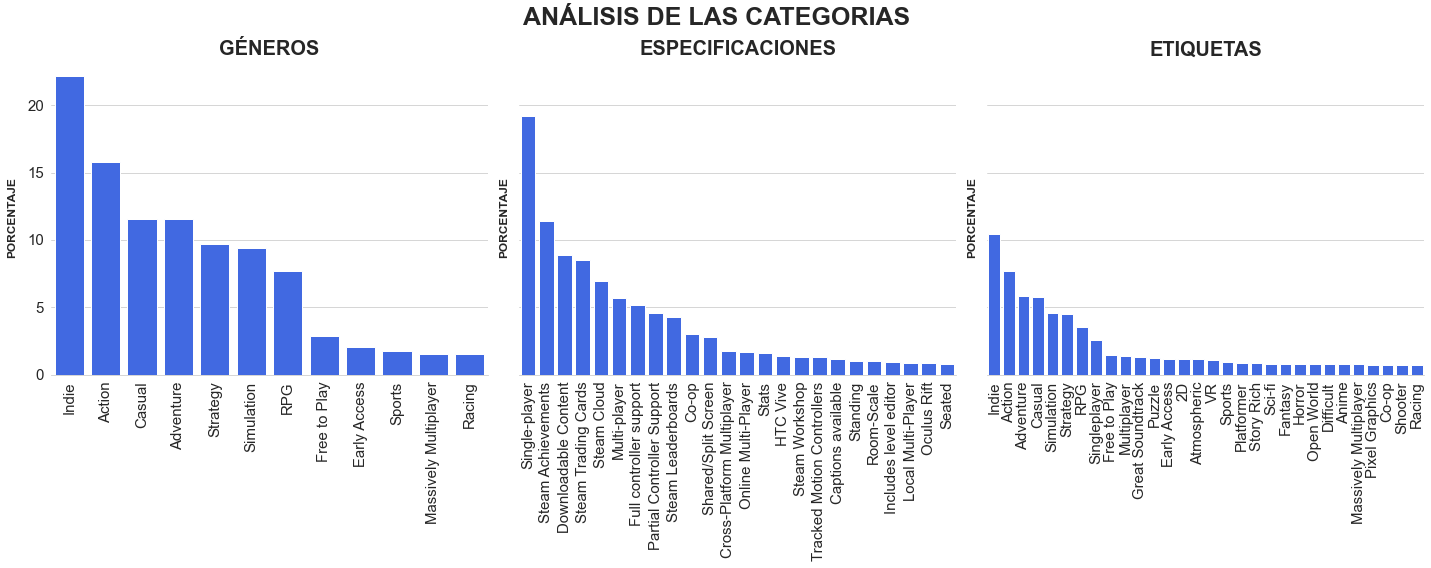

In [21]:
graficar_categorias(0.7)

El atributo ```Etiquetas``` merece un trato especial ya que contiene información que se encuentra en los otros dos atributos. En este caso, principalmente es importante conocer que información nueva puede aportarnos dicho atributo.

In [19]:
specs = get_data('Especificaciones')[1]
genres = get_data('Géneros')[1]
data, tags = get_data('Etiquetas')
tags = list(set(list(set(tags) - set(specs))) - set(genres))

total_cantidad = data['cantidad'].sum()
mask = data.isin(tags).loc[:,'Etiquetas']
data = data[mask].sort_values('cantidad', ascending=False)
data.head()

,Etiquetas,cantidad
261,Singleplayer,4343
183,Multiplayer,2383
128,Great Soundtrack,2233
223,Puzzle,2111
3,2D,1944


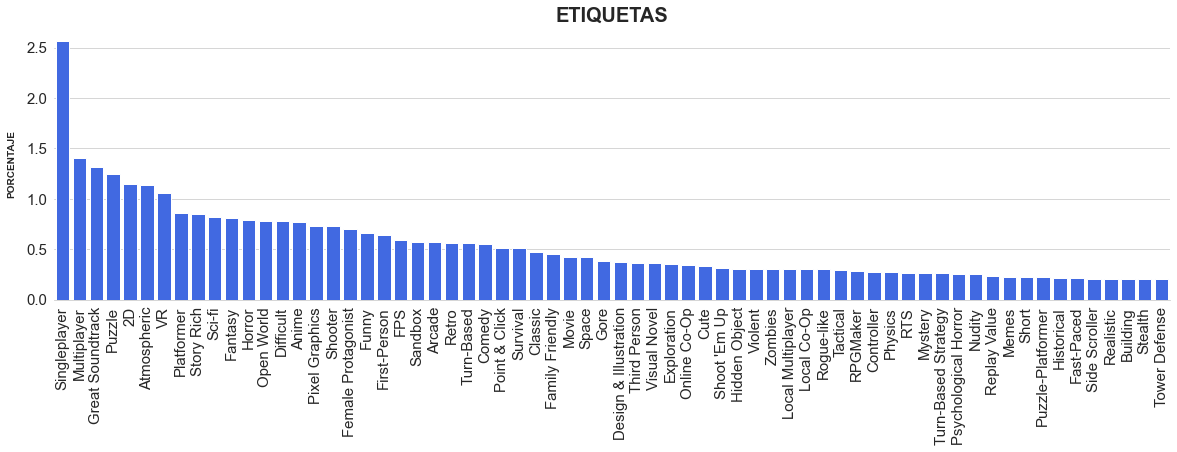

In [23]:
data = data.pivot_table(values='cantidad', index='Etiquetas',
                        aggfunc={'cantidad': lambda x: x*100/total_cantidad.sum()})
data = data.reset_index(drop=False)

plt.figure(figsize=(20,5))
order = data.query('cantidad >= 0.20').sort_values('cantidad', ascending=False).Etiquetas
sns.barplot(x='Etiquetas', y='cantidad', color='Royalblue', data=data.query('cantidad >= 0.20'), order=order, saturation=1)
plt.tick_params(axis='both', labelsize=15)
plt.tick_params(axis='x', rotation=90)
plt.title('Etiquetas'.upper(), fontsize=20, fontweight='bold')
plt.xlabel('')
plt.ylabel('Porcentaje'.upper(), fontsize=10, labelpad=10, weight='bold')
sns.despine(left=True)
plt.show()

Podemos observar en la gráfica de datos perteneciente al atributo ```Etiquetas``` que en la misma contenemos datos que a apenas superan el 2.5% del total. Además, habiendo realizado un filtrado de valores únicos *—datos nuevos que aporta la categoría—* respecto a los otros atributos, encontramos que de nuestro top tres, solo el tercero es información nueva respecto a la que contenemos en los atributos ```Géneros``` y ```Especificaciones```. El mismo no logra superar el 1.5% del total.

*Esta categoría no aporta información nueva de forma significativa*, pero, si nos remitimos a nuestro análisis inicial de valores faltantes, nos encontramos que este atributo es el que menos datos faltantes posee. Por lo tanto, nos ayudaría a rellenar los valores faltantes que no tienen los otros atributos.


Evaluamos cuantos datos podemos completar en la categoría ```Géneros``` y ```Especificaciones```.

In [20]:
genres = games.query('Géneros.isna() & not Etiquetas.isna()', engine='python')
print(f'Existen { genres.shape[0] } registros a completar en la categoría GÉNEROS')
genres.head()

Existen 3144 registros a completar en la categoría GÉNEROS


,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento
4,773570,Log Challenge,NaN,NaN,NaN,"[Single-player, Full controller support, HTC V...","[Action, Indie, Casual, Sports]",http://store.steampowered.com/app/773570/Log_C...,False,2.99,NaN
11,724910,Icarus Six Sixty Six,NaN,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...",[Casual],http://store.steampowered.com/app/724910/Icaru...,False,Free,NaN
19,772590,After Life VR,NaN,NaN,NaN,"[Single-player, HTC Vive, Tracked Motion Contr...","[Early Access, Indie, VR]",http://store.steampowered.com/app/772590/After...,True,4.99,NaN
20,640250,Kitty Hawk,NaN,NaN,NaN,"[Single-player, Steam Leaderboards, HTC Vive, ...","[Early Access, Action, Adventure, Indie, Casual]",http://store.steampowered.com/app/640250/Kitty...,True,2.99,NaN
22,711440,Mortars VR,NaN,NaN,NaN,"[Single-player, Multi-player, Online Multi-Pla...","[Early Access, Strategy, Action, Indie, Casual...",http://store.steampowered.com/app/711440/Morta...,True,0.99,8 user reviews


In [21]:
specs = games.query('Especificaciones.isna() & not Etiquetas.isna()', engine='python')
print(f'Existen { specs.shape[0] } registros a completar en la categoría ESPECIFICACIONES')
specs.head()

Existen 660 registros a completar en la categoría ESPECIFICACIONES


,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento
26,777910,Robotpencil Presents: Understanding 3D for Con...,NaN,2018-01-03,NaN,NaN,"[Design & Illustration, Tutorial]",http://store.steampowered.com/app/777910/Robot...,False,4.99,NaN
738,48220,Might & Magic: Heroes VI,Blackhole,2011-10-13,"[RPG, Strategy]",NaN,"[Strategy, RPG, Turn-Based Strategy, Turn-Base...",http://store.steampowered.com/app/48220/Might_...,False,19.99,Mixed
873,206760,Painkiller: Recurring Evil,Med-Art,2012-02-29,[Action],NaN,"[Action, FPS]",http://store.steampowered.com/app/206760/Paink...,False,9.99,Mixed
1793,257610,LogoMaker 4,Studio V5,2013-12-04,[Design &amp; Illustration],NaN,[Design & Illustration],http://store.steampowered.com/app/257610/LogoM...,False,29.99,Mixed
1828,262650,RaySupreme 3D,BrainDistrict,2013-12-16,[Animation &amp; Modeling],NaN,[Animation & Modeling],http://store.steampowered.com/app/262650/RaySu...,False,39.99,Mostly Negative


Realizamos las imputaciones de los datos faltantes y vemos cuáles quedaron fuera.

In [22]:
val_genres = completar(genres, 'Géneros')
val_specs = completar(specs, 'Especificaciones')

print('DATOS QUE NO SE TOMAN EN CUENTA LUEGO DE RELLENAR LOS VALORES FALTANTES')
val_genres = list(map(str.lower, np.unique(val_genres, return_counts=False)))
print('\nEtiquetas que quedaron afuera para géneros:\n', val_genres)
val_specs = list(map(str.lower, np.unique(val_specs, return_counts=False)))
print('\nEtiquetas que quedaron afuera para especificaciones:\n', val_specs)

DATOS QUE NO SE TOMAN EN CUENTA LUEGO DE RELLENAR LOS VALORES FALTANTES

Etiquetas que quedaron afuera para géneros:
 ['1980s', "1990's", '2d', '360 video', '3d platformer', '3d vision', 'action rpg', 'action-adventure', 'aliens', 'animation & modeling', 'anime', 'arcade', 'assassin', 'based on a novel', 'basketball', "beat 'em up", 'bullet hell', 'cartoon', 'character customization', 'chess', 'cinematic', 'classic', 'cold war', 'comedy', 'comic book', 'controller', 'crime', 'cute', 'cyberpunk', 'dark comedy', 'dark fantasy', 'dating sim', 'demons', 'design & illustration', 'detective', 'difficult', 'documentary', 'dragons', 'drama', 'episodic', 'fps', 'faith', 'family friendly', 'fantasy', 'female protagonist', 'football', 'foreign', 'funny', 'futuristic', 'game development', 'gaming', 'gore', 'great soundtrack', 'hack and slash', 'hacking', 'hardware', 'hidden object', 'historical', 'horror', 'illuminati', 'isometric', 'jrpg', 'kickstarter', 'local multiplayer', 'mmorpg', 'magic', 'm

Luego de haber aplicado correctamente las funciones que se crearon, podemos observar que existen valores faltantes en las columnas que planeabamos completar. Esto sucede ya que la información que proporciona la columna ```Etiquetas``` no pertenece a ninguna columna, es decir, son datos nuevos.

In [25]:
total = games.query('Especificaciones.isna() | Géneros.isna()', engine='python').shape[0]
print(f'Existen { total } registros donde no se pudieron realizar las imputaciones.')
games.query('Especificaciones.isna() | Géneros.isna()', engine='python').sample(10)

Existen 1379 registros donde no se pudieron realizar las imputaciones.


,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento,Metascore
6618,275030,Punch! ViaCAD 2D/3D v9 + 3D Printing PowerPack LT,Evolution Software,2016-07-13,"[Animation &amp; Modeling, Design &amp; Illust...",NaN,"[Design & Illustration, Animation & Modeling]",http://store.steampowered.com/app/275030/Punch...,False,99.99,9 user reviews,NaN
18142,609500,Comedy Dynamics: Coming to The Stage,<NA>,2015-05-06,NaN,[Captions available],[Episodic],http://store.steampowered.com/app/609500/Comed...,False,29.99,NaN,NaN
15016,726400,Aliens: Zone-X,<NA>,2016-08-25,NaN,[Captions available],[Movie],http://store.steampowered.com/app/726400/Alien...,False,4.99,NaN,NaN
17050,668180,Ghost Ship,<NA>,NaN,NaN,"[HTC Vive, Oculus Rift, Tracked Motion Control...","[360 Video, Short]",http://store.steampowered.com/app/668180/Ghost...,False,Free,3 user reviews,NaN
14586,734190,GAMERS!,<NA>,2017-10-26,NaN,NaN,"[Episodic, Anime]",http://store.steampowered.com/app/734190/GAMERS/,False,1.99,4 user reviews,NaN
18505,615720,Jimmy Dore: Sentenced to Live,<NA>,2011-09-26,NaN,[Captions available],[Movie],http://store.steampowered.com/app/615720/Jimmy...,False,3.99,1 user reviews,NaN
11899,728520,Still Breathing,<NA>,1998-05-01,NaN,[Captions available],[Movie],http://store.steampowered.com/app/728520/Still...,False,4.99,NaN,NaN
23413,421440,Rounders,<NA>,1999-02-09,NaN,[Captions available],"[Movie, Drama, Crime]",http://store.steampowered.com/app/421440/Round...,False,3.99,NaN,NaN
23073,459480,Leap of Fate - Soundtrack,Vibe Avenue,2016-05-20,NaN,[Downloadable Content],NaN,http://store.steampowered.com/app/459480/Leap_...,False,3.99,1 user reviews,NaN
8877,597800,Eugene Mirman: Vegan On His Way To The Complai...,<NA>,2015-07-01,NaN,[Captions available],[Movie],http://store.steampowered.com/app/597800/Eugen...,False,3.99,NaN,NaN


Verificamos los valores nulos que no pueden ser completados ya que, la columna ```Género``` posee datos faltantes, la columna ```Especificaciones``` posee datos faltantes y la columna ```Etiquetas``` también posee datos faltantes.

In [24]:
total = games.query('Especificaciones.isna() & Géneros.isna() & Etiquetas.isna()', engine='python').shape[0]
print(f'Existen { total } registros donde las tres columnas son nulas.')
games.query('Especificaciones.isna() & Géneros.isna() & Etiquetas.isna()', engine='python')

Existen 7 registros donde las tres columnas son nulas.


,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento
5373,382990,BrainBread 2 Mod Tools,NaN,2016-02-17,NaN,NaN,NaN,http://store.steampowered.com/app/382990/Brain...,False,NaN,NaN
9560,582400,Alien Swarm: Reactive Drop Dedicated Server,NaN,2017-04-20,NaN,NaN,NaN,http://store.steampowered.com/app/582400/Alien...,False,NaN,NaN
21335,531340,Steam Controller Skin - CSGO Blue/Orange,NaN,2016-09-29,NaN,NaN,NaN,http://store.steampowered.com/app/531340/Steam...,False,9.99,NaN
21336,531360,Steam Controller Skin - CSGO Grey Camo,NaN,2016-09-29,NaN,NaN,NaN,http://store.steampowered.com/app/531360/Steam...,False,9.99,NaN
21337,531430,Steam Link Skin - CSGO Blue/Orange,NaN,2016-09-29,NaN,NaN,NaN,http://store.steampowered.com/app/531430/Steam...,False,9.99,NaN
23326,451330,IS Defense Editor,NaN,2016-04-29,NaN,NaN,NaN,http://store.steampowered.com/app/451330/IS_De...,False,NaN,6 user reviews
27738,338440,BOMB Dedicated Server,NaN,2014-12-17,NaN,NaN,NaN,http://store.steampowered.com/app/338440/BOMB_...,False,NaN,NaN


Inicialmente, eliminamos estos registros y luego procedemos a eliminar aquellos valores nulos de las listas luego de haber creado una única variable que agrupe los datos de las tres categorías.

In [23]:
idx = games.query('Especificaciones.isna() & Géneros.isna() & Etiquetas.isna()', engine='python').index
games.drop(idx, inplace=True)

Llenamos los valores nulos de nuestras categorías con listas vacias y formateamos las cadenas de caracteres de nuestros atributos categóricos con la finalidad de eliminar apóstrofes, mayúsculas, guiones medios, etc.

In [24]:
for column in ['Géneros', 'Especificaciones', 'Etiquetas']:
    games[column].fillna({ i: [] for i in games.index }, inplace=True)
    games[column] = games[column].map(lambda x: [ re.sub(r'[^\w\s]', '', item).lower() for item in x])

---
**PRECIO**

---

Por útlimo, analizamos el atributo precio.

In [25]:
precios = np.array([i for i in list(games.Precio) if (type(i) == str)])
np.unique(precios)

array(['Free', 'Free Demo', 'Free HITMAN™ Holiday Pack', 'Free Mod',
       'Free Movie', 'Free To Play', 'Free to Play', 'Free to Try',
       'Free to Use', 'Install Now', 'Install Theme', 'Play Now',
       'Play WARMACHINE: Tactics Demo', 'Play for Free!', 'Play the Demo',
       'Starting at $449.00', 'Starting at $499.00', 'Third-party'],
      dtype='<U29')

Transformamos los precios en una variable categórica para identificar cuáles son pagos y cuales gratuitos.

In [26]:
games['Precio'] = games.Precio.apply(lambda p: 'Pago' if (type(p) == float or p.startswith('Starting')) else 'Gratis')
games['Precio'] = games['Precio'].astype('category')
games.head()

,GameID,Aplicación,Desarrollador,Fecha lanzamiento,Géneros,Especificaciones,Etiquetas,Url,Acceso previo,Precio,Sentimiento
0,761140,Lost Summoner Kitty,Kotoshiro,2018-01-04,"[action, casual, indie, simulation, strategy]",[singleplayer],"[strategy, action, indie, casual, simulation]",http://store.steampowered.com/app/761140/Lost_...,False,Pago,NaN
1,643980,Ironbound,Secret Level SRL,2018-01-04,"[free to play, indie, rpg, strategy]","[singleplayer, multiplayer, online multiplayer...","[free to play, strategy, indie, rpg, card game...",http://store.steampowered.com/app/643980/Ironb...,False,Gratis,Mostly Positive
2,670290,Real Pool 3D - Poolians,Poolians.com,2017-07-24,"[casual, free to play, indie, simulation, sports]","[singleplayer, multiplayer, online multiplayer...","[free to play, simulation, sports, casual, ind...",http://store.steampowered.com/app/670290/Real_...,False,Gratis,Mostly Positive
3,767400,弹炸人2222,彼岸领域,2017-12-07,"[action, adventure, casual]",[singleplayer],"[action, adventure, casual]",http://store.steampowered.com/app/767400/2222/,False,Pago,NaN
4,773570,Log Challenge,NaN,NaN,"[sports, indie, casual, action]","[singleplayer, full controller support, htc vi...","[action, indie, casual, sports]",http://store.steampowered.com/app/773570/Log_C...,False,Pago,NaN


Transformamos los precios en una variable categórica para identificar cuáles son pagos y cuáles gratuitos.

In [33]:
games.isna().sum()

GameID                  0
Aplicación              0
Desarrollador        3295
Fecha lanzamiento    2064
Géneros                 0
Especificaciones        0
Etiquetas               0
Url                     0
Acceso previo           0
Precio                  0
Sentimiento          7179
dtype: int64

#### Análisis de variables categóricas

Analizamos las variables categóricas con el fín de pulir los datos y que los mismos tengan consistencia. De aquí, se puede observar que los atributos que destacan son: ```Géneros```, ```Etiquetas```, ```Especificaciones```, ```Precio``` y ```Acceso previo```.

---
**Géneros, etiquetas y especificaciones**

---
En estos tres atributos, los registros contienen listas en sus campos; necesitamos crear una columna única que extraiga las carácteristicas de cada registro.

In [27]:
games['Categorías'] = games['Especificaciones'] + games['Etiquetas'] + games['Géneros']
games['Categorías'] = [np.unique(category) for category in games.Categorías]

In [28]:
np.unique(list(itertools.chain(*games['Categorías'])))

array(['1980s', '1990s', '25d', '2d', '2d fighter', '360 video',
       '3d platformer', '3d vision', '4 player local', '4x', '6dof',
       'abstract', 'accounting', 'action', 'action rpg',
       'actionadventure', 'adventure', 'agriculture', 'aliens',
       'alternate history', 'america', 'animation  modeling',
       'animation amp modeling', 'anime', 'arcade', 'arena shooter',
       'artificial intelligence', 'assassin', 'asynchronous multiplayer',
       'atmospheric', 'audio production', 'base building',
       'based on a novel', 'basketball', 'batman', 'beat em up',
       'benchmark', 'bikes', 'blood', 'board game', 'bowling', 'building',
       'bullet hell', 'bullet time', 'capitalism', 'captions available',
       'card game', 'cartoon', 'cartoony', 'casual',
       'character action game', 'character customization', 'chess',
       'choices matter', 'choose your own adventure', 'cinematic',
       'city builder', 'classbased', 'classic', 'clicker', 'cold war',
       'c

Estos son las características únicas que poseen cada videojuegos. Llegado a este punto se puede realizar un filtrado eliminando buscando videojuegos, aplicaciones de edición, etc.

Eliminamos las columnas `Desarrollador`, `Especificaciones`, `Etiquetas`, `Fecha lanzamiento`, `Géneros`, `Sentimiento` y `Url` ya que cumplieron con su propósito en está etapa.

In [28]:
games.drop(columns=['Desarrollador', 'Especificaciones', 'Etiquetas', 'Fecha lanzamiento', 'Géneros', 'Sentimiento', 'Url'], inplace=True)
games.sample(5)

,GameID,Aplicación,Acceso previo,Precio,Categorías
1490,225428,Cities in Motion 2: Wending Waterbuses,False,Pago,"[coop, crossplatform multiplayer, downloadable..."
27801,302570,Dangerous,False,Pago,"[action, adventure, captions available, indie,..."
2025,289280,El Matador,False,Pago,"[action, bullet time, shooter, singleplayer, t..."
31753,16030,7 Wonders: Treasures of Seven,False,Pago,"[casual, match 3, puzzle, singleplayer]"
27537,343800,Shadowgate: MacVenture Series,False,Pago,"[1980s, adventure, atmospheric, classic, dark ..."


In [29]:
games.reset_index(drop=True, inplace=True)
games['GameID'] = games['GameID'].astype('uint32')
games['Aplicación'] = games['Aplicación'].astype('string')
games['Acceso previo'] = games['Acceso previo'].astype('category')
games['Precio'] = games['Precio'].astype('category')
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32122 entries, 0 to 32121
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   GameID         32122 non-null  uint32  
 1   Aplicación     32122 non-null  string  
 2   Acceso previo  32122 non-null  category
 3   Precio         32122 non-null  category
 4   Categorías     32122 non-null  object  
dtypes: category(2), object(1), string(1), uint32(1)
memory usage: 690.5+ KB


## **Análisis exploratorio de datos**

En esta sección se pretende analizar los dataset para entender los mismos y extraer información que nos puede ayudar a generar un mejor *sistema de recomendación*.

### Merge

Hacemos el unificado de los datasets a través de la columna ```GameID```, que poseen en común.

In [32]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3634606 entries, 2768979 to 3400554
Data columns (total 7 columns):
 #   Column        Dtype  
---  ------        -----  
 0   Usuario       object 
 1   Cant. horas   float64
 2   Cant. juegos  float64
 3   Fecha         object 
 4   Comentario    object 
 5   Preview       bool   
 6   GameID        object 
dtypes: bool(1), float64(2), object(4)
memory usage: 197.6+ MB


In [30]:
reviews_games = reviews.merge(games, how='left', on='GameID', suffixes=('REVIEWS_', 'GAMES_'))
reviews_games.head()

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID,Aplicación,Acceso previo,Precio,Categorías
0,No Man's Sky,3.000000,10.0,2018-01-05,finaly a game that has everything to do about ...,False,504370,Battlerite,False,Gratis,"[action, arena shooter, atmospheric, beat em u..."
1,Ori,26.900000,47.0,2018-01-05,Buy it play it love it,False,447530,VA-11 Hall-A: Cyberpunk Bartender Action,False,Pago,"[adventure, anime, atmospheric, casual, choice..."
2,mhputnam27,261.299988,6.0,2018-01-05,Spelunky is my favorite game. I feel like a lo...,False,239350,Spelunky,False,Pago,"[2d, action, adventure, controller, coop, diff..."
3,Pink Panther,3.300000,41.0,2018-01-05,Terrorist !,False,239350,Spelunky,False,Pago,"[2d, action, adventure, controller, coop, diff..."
4,⚡ SCARLETT SPEEDSTER ⚡,259.000000,1.0,2018-01-05,Ok SO IF YOU WANT HACKERS IN EVERY MATCH THEN ...,False,730,Counter-Strike: Global Offensive,False,Pago,"[action, competitive, coop, difficult, esports..."


Verificamos que los registros correspondientes a los comentarios de los usuarios estén haciendo referencia a un producto que tengamos en nuestro dataset de videojuegos.

In [35]:
reviews_games.isna().sum()

Usuario          0
Cant. horas      0
Cant. juegos     0
Fecha            0
Comentario       0
Preview          0
GameID           0
Aplicación       0
Acceso previo    0
Precio           0
Categorías       0
dtype: int64

### Visualizaciones

Gráficamos tratando de encontrar algunas respuestas en nuestros datos con la finalidad de tener una mayor comprensión de los mismos.

---
**TOP 10: Usuario con más comentarios**

---

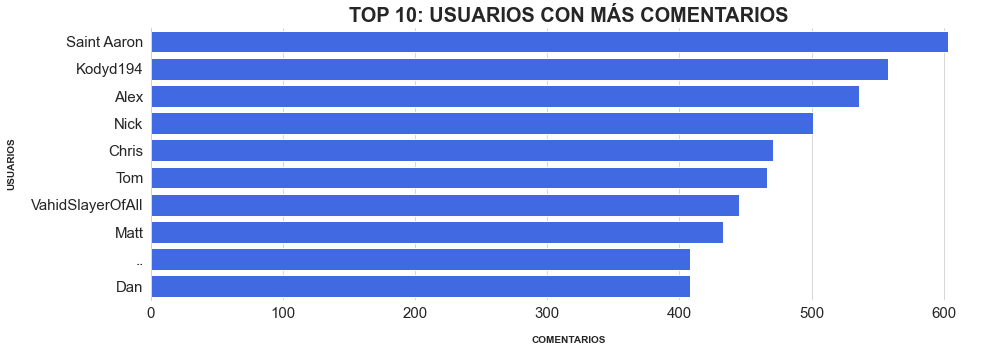

In [33]:
data = reviews_games.groupby('Usuario').agg(Comentarios=pd.NamedAgg(column='Comentario', aggfunc='count')).sort_values('Comentarios',
                                                                                                                       ascending=False)
data.reset_index(inplace=True)
data = data.head(10)

# Gráfica
plt.figure(figsize=(15,5))
sns.barplot(x='Comentarios', y='Usuario', data=data, color='Royalblue', saturation=1)
plt.title('TOP 10: Usuarios con más comentarios'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Comentarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Usuarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(bottom=True)
plt.show()

---
**TOP 10: Juegos con más comentarios**

---

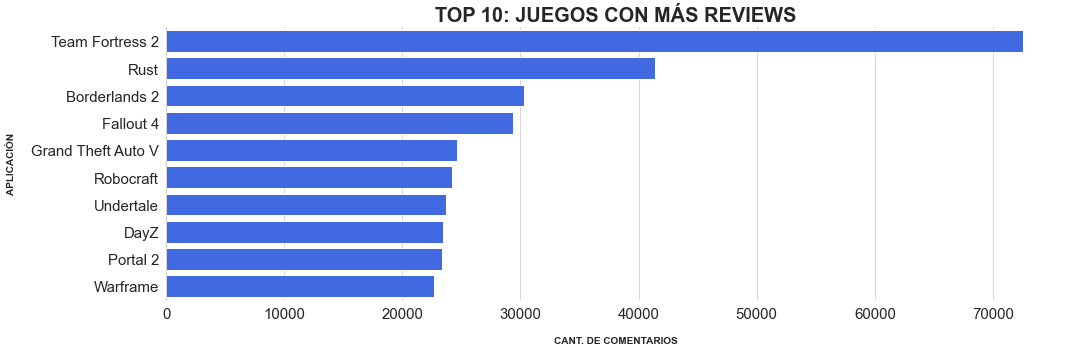

In [34]:
data = reviews_games.groupby('Aplicación').agg(Comentarios=pd.NamedAgg(column='Comentario', aggfunc='count')).sort_values('Comentarios',
                                                                                                                          ascending=False)
data.reset_index(inplace=True)
data = data.head(10)

# Gráfica
plt.figure(figsize=(15,5), tight_layout=True)
sns.barplot(x='Comentarios', y='Aplicación', data=data, color='Royalblue', saturation=1)
plt.title('Top 10: Juegos con más reviews'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Cant. de comentarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Aplicación'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(bottom=True)
plt.show()

Con los datos que contamos es posible analizar que sucede con el acceso anticipado de los diferentes productos.

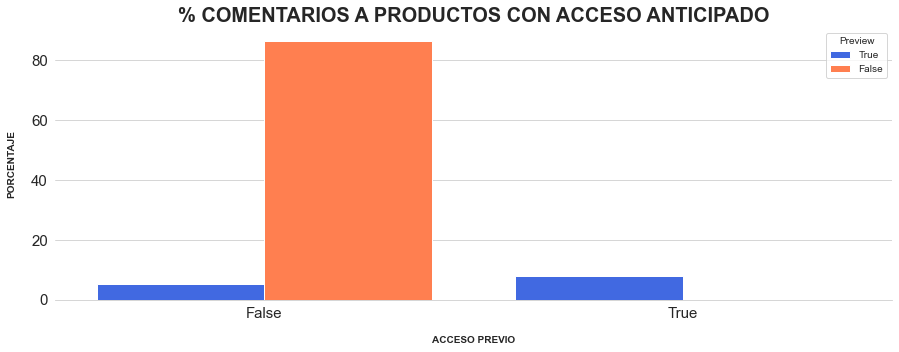

In [36]:
data = reviews_games.groupby(['Acceso previo', 'Preview']).agg(Usuarios=pd.NamedAgg(column='Usuario',
                                                                                    aggfunc=lambda x:len(x)/len(reviews_games)*100))
data.reset_index(inplace=True)

# Gráfica
plt.figure(figsize=(15,5))
sns.barplot(x='Acceso previo', y='Usuarios', data=data, palette=['Royalblue', 'Coral'], hue='Preview', hue_order=[True, False], saturation=1)
plt.title('% comentarios a productos con acceso anticipado'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Acceso previo'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Porcentaje'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(left=True)
plt.show()

Este gráfico a simple vista desconcierta bastante. Antes de entender que sucede, vamos a entender como funciona la estrategia del acceso anticipado: 

> El acceso anticipado o acceso temprano (en inglés, early access) es un modelo de financiación en la industria de los videojuegos por el cual los consumidores pueden pagar por un videojuego en los diversos ciclos de desarrollo (pre alfa, alfa, beta) y obtener acceso a las versiones previas al lanzamiento oficial, mientras que el desarrollador puede usar esos fondos para continuar trabajando en el desarrollo del videojuego.

En este caso, hay usuarios que realizan comentarios sobre productos cuando este se encuentra en etapas tempranas de desarrollo, pero otros, hacen comentarios sobre esos mismos producto cuando este tiene una versión final del mismo. De ahí esas diferencias en los gráficos.

Cuando un producto utilizó la estrategia de acceso anticipado, este capturó a casi el 10% de los usuarios presentes en nuestro dataset.

In [31]:
games_tt = reviews_games.query('`Acceso previo` == True & Preview == True').GameID
games_ft = reviews_games.query('`Acceso previo` == False & Preview == True').GameID

idx_games = games_tt.append(games_ft)
print(f'{ len(idx_games.unique()) } productos tuvieron comentarios en distintas etapas de desarrollo por los usuarios.')

2240 productos tuvieron comentarios en distintas etapas de desarrollo por los usuarios.


Analizamos uno de esos juegos para poder ilustrar lo que se explicó.

In [39]:
cols = ['Usuario', 'Fecha', 'Comentario', 'Preview', 'GameID', 'Aplicación', 'Acceso previo']
reviews_games.loc[:,cols].query('GameID == 346110 & (Preview == True | Preview == False)').sample(2)

,Usuario,Fecha,Comentario,Preview,GameID,Aplicación,Acceso previo
1001473,☣☯†Seleni Uchiha†☯☣,2017-03-04,"Hm I don't have much to say about this game, a...",True,346110,ARK: Survival Evolved,False
493989,HJam,2017-09-03,♥♥♥♥,False,346110,ARK: Survival Evolved,False


Como se observa, el producto **ARK: Survival Evolved** es un juego que ya no se encuentra en etapas de acceso anticipado pero, inicialmente si lo estuvo. De los comentarios que podemos observar, el más antiguo delata esta situación.

Debido a esta inconsistencia en los datos, hacemos las modificaciones necesarias en nuestros datos y volvemos a realizar un merge. Solo queremos corregir aquellos juegos que, en algún momento, tuvieron acceso previo.

In [32]:
idx = games.query('GameID in @idx_games.unique()').index
games.loc[idx,'Acceso previo'] = True

reviews_games = reviews.merge(games, how='left', on='GameID', suffixes=('REVIEWS_', 'GAMES_'))
reviews_games.sample(5)

,Usuario,Cant. horas,Cant. juegos,Fecha,Comentario,Preview,GameID,Aplicación,Acceso previo,Precio,Categorías
3471892,Astijfequn,3.500000,411.0,2013-11-25,Very underrated! Although not many people play...,False,70000,Dino D-Day,False,Pago,"[action, alternate history, comedy, coop, dino..."
2759968,Tohg7.,58.900002,28.0,2015-02-08,alot of the humor comes from the bots u make a...,True,301520,Robocraft,True,Gratis,"[action, adventure, building, crafting, fps, f..."
722774,iakom,1.600000,142.0,2017-06-26,"Absolutely brilliant. Buy it, enjoy it!",False,107100,Bastion,False,Pago,"[2d, action, action rpg, adventure, atmospheri..."
227263,vWatsonic,43.200001,96.0,2017-11-24,Very good yaes,False,208650,Batman™: Arkham Knight,False,Pago,"[action, adventure, atmospheric, batman, beat ..."
2621574,peanut head,41.700001,191.0,2015-05-01,bad,True,221100,DayZ,True,Pago,"[action, adventure, atmospheric, coop, early a..."


Corroboramos nuevamente nuestros datos y vemos que resulta.

In [39]:
usuarios = reviews_games.groupby(['Acceso previo', 'Preview']).agg(Porcentaje=pd.NamedAgg(column='Usuario',
                                                                                          aggfunc=lambda x:len(x)/len(reviews_games)*100))
usuarios.fillna(0, inplace=True)
productos = games.groupby('Acceso previo').agg(Porcentaje=pd.NamedAgg(column='GameID', aggfunc=lambda x: len(x)/len(games)*100))

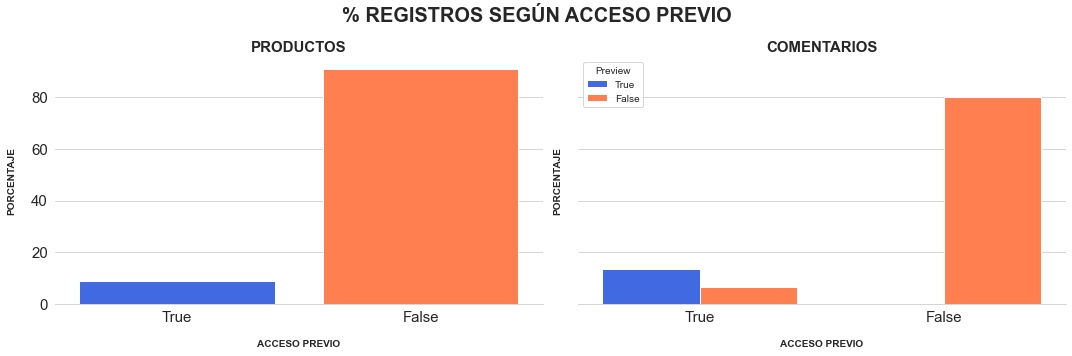

In [40]:
data = [productos, usuarios]

# Gráfica
fig, axs = plt.subplots(1, 2, figsize=(15,5), tight_layout=True, sharey=True)
fig.suptitle('% registros según acceso previo'.upper(), fontsize=20, fontweight='bold')
for x in range(0,2):
    plot = data[x]
    hue = 'Preview' if x > 0 else None
    sns.barplot(x='Acceso previo', y='Porcentaje', data=plot.reset_index(), palette=['Royalblue', 'Coral'], hue=hue, hue_order=[True, False],
                order=[True, False], saturation=1, ax=axs[x])
    axs[x].set_title(f'{ "Productos" if x == 0 else "Comentarios" }'.upper(), fontsize=15, fontweight='bold')
    axs[x].set_xlabel('Acceso previo'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].set_ylabel('Porcentaje'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].tick_params(labelsize=15)
sns.despine(left=True)
plt.show()

Como se puede observar, ya no existen artículos sin acceso previo con comentarios que si eran de dicha instancia del producto. Escasamente, los productos que implementaron dicha estrategia llegan al 10% de nuestros datos *—nos referimos al dataset correspondiente a los videojuegos—*, respecto a los comentarios, sucede algo similar, aunque existe una variación en pos de productos que si se decantaron por dicha estrategia.

---
**Proporcionalidad de comentarios conforme a precio del videojuego discriminando el acceso previo al mismo** 

---

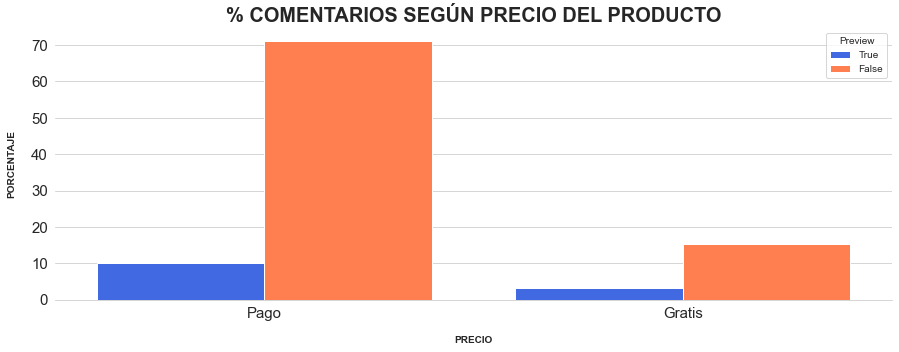

In [41]:
data = reviews_games.groupby(['Precio', 'Preview']).agg(Usuarios=pd.NamedAgg(column='Usuario', aggfunc=lambda x:len(x)/len(reviews_games)*100))
data.reset_index(inplace=True)

# Gráfica
plt.figure(figsize=(15,5))
sns.barplot(x='Precio', y='Usuarios', data=data, hue='Preview', hue_order=[True, False], order=['Pago', 'Gratis'], palette=['Royalblue', 'Coral'],
            saturation=1)
plt.title('% comentarios según precio del producto'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Precio'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Porcentaje'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(left=True)
plt.show()

Aproximadamente, el 80% de los comentarios corresponden a productos que son pagos, dentro de los cuales, más del 70% adquirió el mismo sin ingresar en las etapas previas de desarrollo del mismo, esto es algo esperable, ya que, comúnmente, los usuarios solo buscan un juego que divierta, entretenga, y, sobretodo, no tenga errores ni bugs, algo que es esperable en las primeras fases del producto.

En base a este último gráfico, podemos entender que la gente es más propensa a realizar comentarios y críticas a productos pagos antes que aquellos que son gratis, en este punto no debemos olvidar que el producto con más comentarios es un videojuego gratuito. Entiendo que una causa puede ser que nos es más fácil juzgar *—o nos sentimos con más derecho u obligación como usuario—* aquello que nos implica un esfuerzo adicional, por ejemplo, antes de invertir dinero solemos pasar por un proceso de selección e investigación y resulta frustante si el mismo no llega a nuestras espectativas, por lo tanto, es más probable que hagamos un comentario sobre un producto pago que no nos gusta, no disfrutamos, o no nos llena como usuarios.

Hay que mencionar que los usuarios que deciden ingresar a alphas o betas de productos, lo hacen a sabiendas que pueden encontrarse con errores, bugs o infortuitos, pero, estos usuarios, publican comentarios con la finalidad de generar feedback a los desarrolladores.

De todos modos, es una conjetura y para poder encontrar una respuesta, debemos indagar con más detalle por lo que solo nos resta continuar en nuestro análisis, por ello, vamos a adentrarnos en el análisis de esta porción de nuestros datos, productos que permitieron a los usuarios acceder a etapas previas del desarrollo; inicialmente, identificamos los ***usuarios que tuvieron acceso anticipado a los diferentes productos***.

In [42]:
mask = reviews_games['Acceso previo'] == True
idx = reviews_games[mask].GameID.unique()
data = reviews_games.query('GameID in @idx')

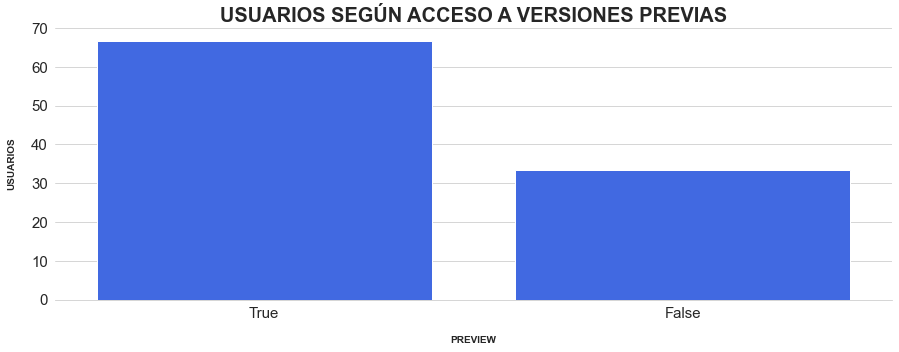

In [43]:
plot = data.pivot_table(index='Preview', values='Usuario', aggfunc=lambda x: len(x.unique()))
plot['Usuario'] = plot['Usuario']/plot['Usuario'].sum()*100
plot = plot.reset_index()

# Gráfica
plt.figure(figsize=(15,5))
order = plot.sort_values('Usuario', ascending=False).Preview
sns.barplot(x='Preview', y='Usuario', data=plot, color='Royalblue', order=order, saturation=1)
plt.title('usuarios según acceso a versiones previas'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Preview'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Usuarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(left=True)
plt.show()

Como se observa, aproximadamente el doble de usuarios decidieron ingresar al acceso anticipado de los productos. Continuamos analizando esta porción de nuestros datos, productos que si implementaron el acceso previo para los usuarios, indentificando el ***total de productos que son pagos versus aquellos que son gratuitos***.

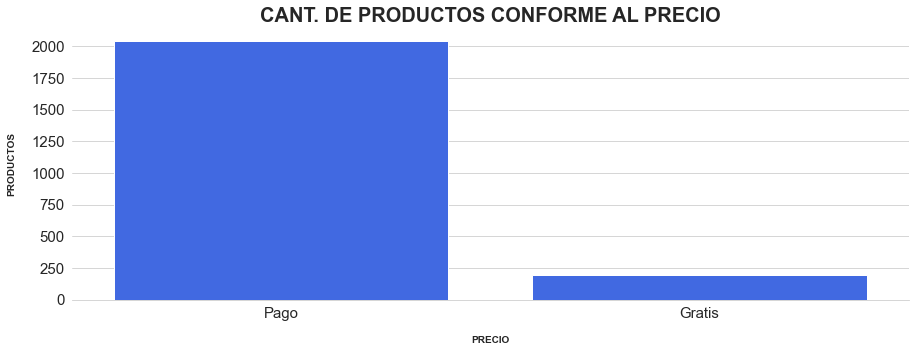

In [44]:
plot = data.pivot_table(index='Precio', values='GameID', aggfunc=lambda x: len(x.unique()))

# Gráfica
plt.figure(figsize=(15,5))
sns.barplot(x=plot.index, y='GameID', data=plot, color='Royalblue', order=['Pago', 'Gratis'], saturation=1)
plt.title('Cant. de productos conforme al precio'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Precio'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Productos'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(left=True)
plt.show()

En estas últimas dos gráficas visualizamos la cantidad de usuarios que ingresaron en etapas previas del desarrollo, más del 65% optó por esta modalidad. A su vez, se pude destacar que dicha estrategia es una práctica orientada a productos pagos. Aquí, es importante entender que los desarrolladores aprovechan la retroalimentación de los usuarios en las etapas previas, con la finalidad de mejorar el producto para luego llegar a un mayor público una vez que este llegó a una versión estable final. Sería interesante conocer cuantos de aquellos productos consiguieron una mejor calificación una vez que se liberó al público la versión final.

Si juntamos estas dos gráficas en una obtenemos lo siguiente:

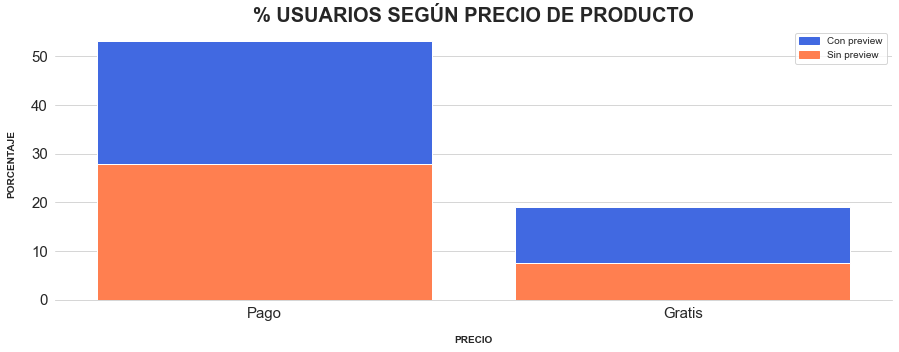

In [45]:
total = data.pivot_table(index='Precio', values='Usuario', aggfunc=lambda x: len(x.unique())).sum()
plot = data.pivot_table(index='Precio', columns='Preview', values='Usuario', aggfunc=lambda x: len(x.unique()))
plot = plot.unstack().reset_index()
plot.rename(columns={0: 'Total usuarios'}, inplace=True)
plot['Total usuarios'] = plot['Total usuarios']/total.values*100

# Gráfica
plt.figure(figsize=(15,5))
preview = plot.query('Preview == True')
sns.barplot(x='Precio', y='Total usuarios', data=preview, color='Royalblue', order=['Pago', 'Gratis'], saturation=1)
preview = plot.query('Preview == False')
sns.barplot(x='Precio', y='Total usuarios', data=preview, color='Coral', order=['Pago', 'Gratis'], saturation=1)
top = mpatches.Patch(color='Royalblue', label='Con preview')
bottom = mpatches.Patch(color='Coral', label='Sin preview')
plt.title('% Usuarios según precio de producto'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Precio'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Porcentaje'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.legend(handles=[top, bottom], fontsize=10)
sns.despine(left=True)
plt.show()

Observamos que la mayoría de usuarios tuvieron acceso anticipado a diferentes artículos, sin importar que el mismo fuese pago o no. Cada vez queda más claro la efectividad de dicha estrategia.

Continuamos desmenuzando nuestros datos, observamos las distribuciones de los usuarios según el acceso previo de los productos, siempre mirando aquellos productos que si implementaron dicha estrategia. Estamos tratando de entender que sucede con esos artículos y porque los usuarios se decantan, o no, por participar en versiones previas de desarrollo.

In [46]:
plot = data.pivot_table(index='GameID', columns='Preview', values='Usuario', margins=True, aggfunc='count').rename(columns={ 'All' : 'Totales' })
plot.describe()

Preview,False,True,Totales
count,2241.000000,2241.000000,2241.000000
mean,208.130299,437.388666,645.518965
std,4950.012627,10443.136578,15358.918907
min,0.000000,1.000000,1.000000
25%,0.000000,4.000000,6.000000
50%,0.000000,13.000000,21.000000
75%,17.000000,57.000000,106.000000
max,233210.000000,490094.000000,723304.000000


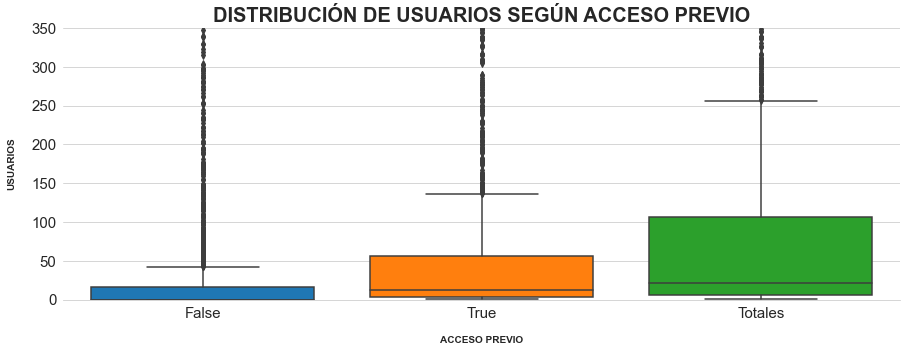

In [47]:
# Gráfica
plt.figure(figsize=(15,5))
sns.boxplot(data=plot, saturation=1)
plt.title('Distribución de usuarios según acceso previo'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Acceso previo'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Usuarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylim(0,350)
sns.despine(left=True)
plt.show()

En la siguiente gráfica visualizamos los ***diez productos que acapararon a la mayor cantidad de usuarios y los diez productos que peor les fue con esta estrategia***. La idea de esta gráfica no es conocer los productos que no tuvieron tantos adeptos.

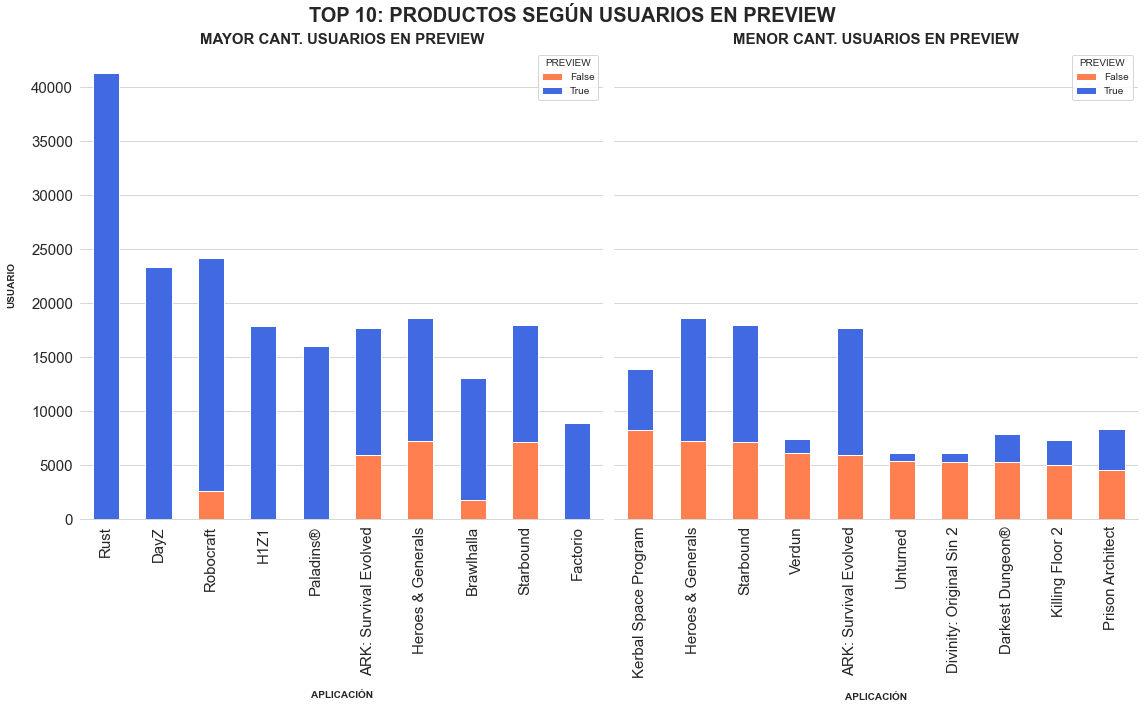

In [48]:
plot = plot.merge(games.loc[:,['GameID', 'Aplicación']], how='inner', left_on='GameID', right_on='GameID')
columns = [True, False]

# Gráfica
fig, axs = plt.subplots(1, 2, figsize=(16,10), tight_layout=True, sharey=True)
fig.suptitle('Top 10: Productos según usuarios en preview'.upper(), fontsize=20, fontweight='bold')
for x in range(0,2):
    var = columns[x]
    plot.sort_values(by=var, ascending=False, inplace=True)
    plot.head(10).drop(columns=['GameID', 'Totales']).plot(ax=axs[x], color=['Coral', 'Royalblue'], kind='bar', stacked=True, x='Aplicación',
                                                           xlabel='')
    axs[x].legend(title='Preview'.upper())
    subtitle = f'{ "Mayor" if var == True else "Menor" } cant. usuarios en preview'.upper()
    axs[x].set_title(subtitle, fontsize=15, fontweight='bold')
    axs[x].set_xlabel('Aplicación'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].set_ylabel('Usuario'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].tick_params(labelsize=15)
    axs[x].grid(axis='x')
sns.despine(left=True)
plt.show()

Como podemos observar, hay productos que lograron que el 100% de los usuarios que accedieron al avance del mismo, realizaron un comentario sobre el producto *—vale hacer algunas aclaraciones, nuestros datos de origen cuenta con 7.793.069 de comentarios y por razones de procesamiento, solo se utilizó la mitad—*. Esto demuestra el nivel de espectativa y emoción que tenían los usuarios por dichos productos junto a las ganas de compartir su experiencia en las etapas iniciales del producto.

De lo analizado hasta el momento, no encontramos ningún análisis que nos pueda indicar que sucede en la interacción usuario-producto. Solo nos hemos limitado a comprender que sucede por encima, rascamos la superficie de nuestro universo *—recordemos que centramos el análisis en aquellos productos que alguna vez implementaron el acceso previo para los usuarios—*, hicimos algunas segmentación, detectamos poblaciones pero no entramos en el comportamiento de los usuarios utilizando dichos productos. Para este cometido, encontramos el atributo `Cant. horas`, el cuál nos indica el tiempo que un usuario pasa utilizando el producto al momento de realizar un comentario.

Orientamos nuestro análisis para poner énfasis en ese objetivo.

In [51]:
data.loc[:,['Cant. horas', 'Cant. juegos']].describe()

,Cant. horas,Cant. juegos
count,723292.000000,723292.000000
mean,119.415596,181.506485
std,338.254272,392.262421
min,0.000000,1.000000
25%,4.800000,36.000000
50%,21.100000,86.000000
75%,86.800003,193.000000
max,18549.800781,12832.000000


En nuestros resumen de datos estadísticos encontramos que existe una gran dispersión en los datos, se puede observar que la desviación estandar es de casi 400 productos y de 14 días respecto a la cantidad de horas. 

Analizando el atributo `Cant. de productos` me encuentro con lo siguiente: dicho atributo lo tomé como las transacciones que tiene hechas el usuario *—si se hizo una compra/instalación de x cantidad de artículos de la tienda—* al momento de realizar un comentario.

In [476]:
user = 'Ori'
data.query('Usuario == @user').loc[:,['Usuario', 'Cant. juegos', 'Fecha', 'Aplicación']].sort_values(by='Fecha', ascending=False)

,Usuario,Cant. juegos,Fecha,Aplicación
166775,Ori,69.0,2017-11-28,Endless Space® 2
864727,Ori,47.0,2017-05-07,BeamNG.drive
1481330,Ori,111.0,2016-09-25,CHKN
1722066,Ori,46.0,2016-06-16,Robocraft
3134448,Ori,266.0,2014-07-01,Divinity: Original Sin (Classic)


Analizando un usuario y dicho atributo, me encuentro que a lo largo del tiempo este número varía mucho, tanto de forma creciente como decreciente. Por dicho motivo y debido a la falta de interpretación no lo tomó en cuenta con la certeza que no puedo extraer todo el jugo que se puede exprimir al mismo para obtener mejores predicciones en el modelo final.

Respecto a la cantidad de horas vemos lo siguiente:

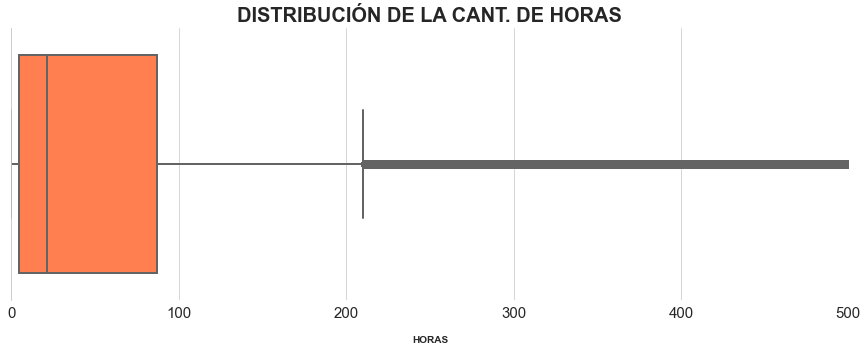

In [49]:
# Gráfica
plt.figure(figsize=(15,5))
sns.boxplot(x='Cant. horas', data=data, color='Coral', linewidth=2, saturation=1)
plt.title('Distribución de la cant. de horas'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Horas'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.xlim(0,500)
sns.despine(bottom=True)
plt.show()

Como se observa, tenemos una *distribución con asimetría positiva*, *la mediana es menor a un día*; también se observa una *gran presencia de outliers*. Completamos el gráfico anterior realizando una ***comparación de las distribuciones de las cantidad de horas de los usuarios según el acceso anticipado***.

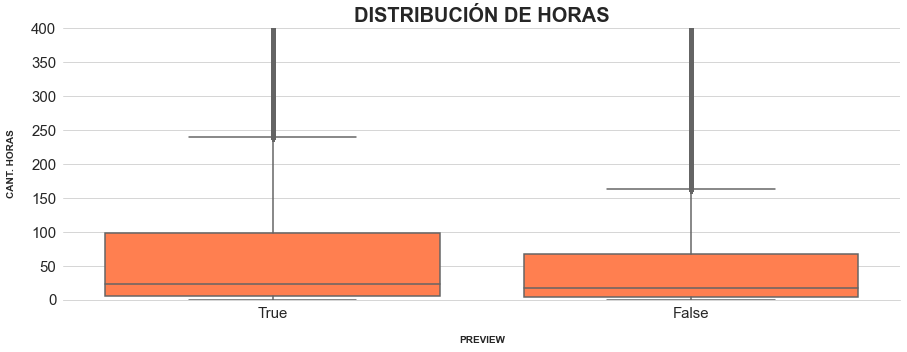

In [50]:
# Gráfica
plt.figure(figsize=(15,5))
plt.title(f'Distribución de horas'.upper(), fontsize=20, fontweight='bold')
sns.boxplot(x='Preview', y='Cant. horas', data=data, color='Coral', order=[True, False], saturation=1)
plt.tick_params(axis='both', labelsize=15)
plt.xlabel('Preview'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel(f'Cant. horas'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylim(0,400)
sns.despine(left=True)
plt.show()

Como se puede observar, los usuarios que si accedieron al preview de los productos tienen una mayor distribución en la cantidad de horas, esto nos da un indicio como funcióna la estrategia en los usuarios. Continuamos nuestro análisis discriminando aquellos usuarios que realizaron ***comentarios en productos con acceso previo pero este lo hizo en distintas instancias***, o sea, usuarios que comentaron alguna vez en etapas iniciales de algún juego y en etapas finales de otros.

In [51]:
table = data.pivot_table(index='Usuario', columns='Preview', values='GameID', aggfunc='count')
mask = (table.iloc[:,0] > 1) & (table.iloc[:,1] > 1)
idx = table[mask].index
users = reviews_games.query('Usuario in @idx')

#cols = ['Acceso previo', 'Preview']
summary_users = users.pivot_table(index=['Usuario'], columns='Preview', values='Cant. horas').agg(['sum', 'mean', 'count'])
summary_users.rename(index={'sum': 'Acumuladas', 'mean': 'Promedio', 'count': 'Total usuarios'}, inplace=True)
plot = summary_users.T
plot.index.rename(name='Preview', inplace=True)

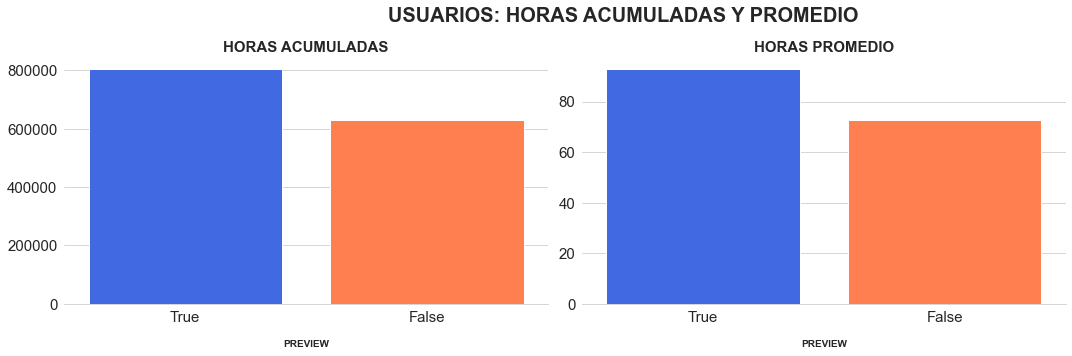

In [52]:
col = ['Acumuladas', 'Promedio']

# Gráfica
fig, axs = plt.subplots(1, 2, figsize=(15,5), tight_layout=True)
fig.suptitle('Usuarios: Horas acumuladas y promedio'.upper(), x=.58, fontsize=20, fontweight='bold')
for x in range(0,2):
    var = col[x]
    sns.barplot(y=var, x='Preview', data=plot.reset_index(), palette=['Royalblue', 'Coral'], order=[True, False], saturation=1, ax=axs[x])
    axs[x].set_title(f'Horas { var }'.upper(), fontsize=15, fontweight='bold')
    axs[x].set_ylabel('')
    axs[x].set_xlabel('Preview'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].tick_params(labelsize=15)
sns.despine(left=True)
plt.show()

El comportamiento de los usuarios que participan activamente en los productos, cuando este pone en marcha el acceso previo al mismo, nos dice que estos pasan mayor tiempo utilizando los mismos, son usuarios proactivos en el uso de los productos.

A continuación vemos como afecta el precio de los productos a los usuarios.

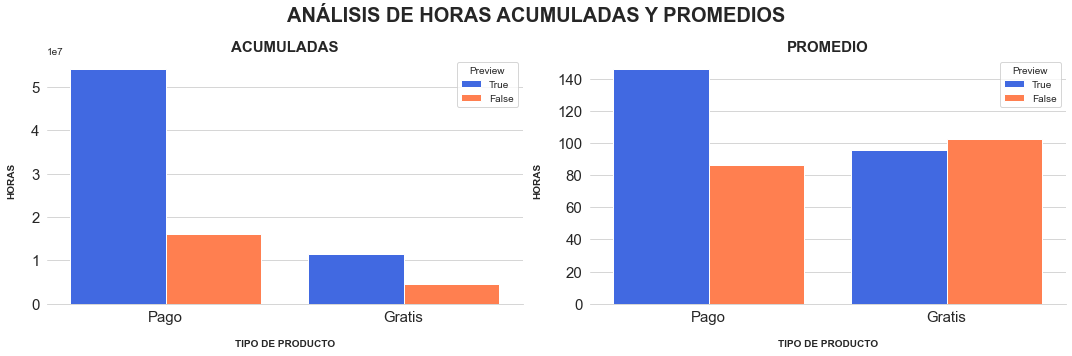

In [53]:
plot = data.groupby(by=['Precio', 'Preview'])['Cant. horas'].agg(['sum', 'mean']).rename(columns={'sum': 'Acumuladas', 'mean': 'Promedio'})
plot.reset_index(inplace=True)

# Gráfica
var = ['Acumuladas', 'Promedio']
fig, axs = plt.subplots(1,2, figsize=(15,5), tight_layout=True)
for x in range(0,2):
    func = var[x]
    sns.barplot(x='Precio', y=func, data=plot, palette=['Royalblue', 'Coral'], hue='Preview', hue_order=[True, False], order=['Pago', 'Gratis'],
                saturation=1, ax=axs[x])
    axs[x].set_title(f'{ func }'.upper(), fontsize=15, fontweight='bold')
    axs[x].set_xlabel('Tipo de producto'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].set_ylabel('Horas'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].tick_params(labelsize=15)
fig.suptitle('Análisis de horas acumuladas y promedios'.upper(), fontsize=20, fontweight='bold')
sns.despine(left=True)
plt.show()

De la imagen previa podemos observar como los usuarios que acceden a un avance de un producto son los que mayor tiempo invierten en la plataforma, se puede inferir que son usuarios corrientes en el mundo gamer, que disfrutan de los productos, los estrujan, para luego pasar al siguiente; para estos usuarios, el precio, no es una barrera para el entretenimiento. Un dato adicional, el promedio de horas de los usuarios sin ingreso al anticipo de un producto, el cúal es gratuíto, es similar al de los usuarios que sí lo hicieron, pero el de estos últimos es menor.

In [82]:
table = data.pivot_table(index='GameID', columns='Preview', values='Usuario', aggfunc='count')
idx_true = table.sort_values(by=True, ascending=False).index
idx_false = table.sort_values(by=False, ascending=False).index

In [130]:
columns = [ 'GameID', 'Aplicación', 'Acumuladas', 'Promedio' ]
rename = { 'sum': 'Acumuladas', 'mean': 'Promedio' }
labels = { ('Acumuladas', 'Cant. horas') : 'Acumuladas', ('Promedio', 'Cant. horas') : 'Promedio' }

# Juegos con mayor cantidad de usuarios que ingresaron al accceso previo.
preview_true = data.query('GameID in @idx_true & Preview == True')
preview_true = preview_true.pivot_table(index='GameID', values='Cant. horas', aggfunc=['sum', 'mean'],
                                        fill_value=0).rename(columns=rename).fillna(0)
preview_true = preview_true.merge(games.loc[:,columns[:2]], how='inner', left_on='GameID', right_on='GameID')
preview_true.rename(columns=labels, inplace=True)

# Juegos con menor cantidad de usuarios que ingresaron al accceso previo estando esta disponible.
preview_false = data.query('GameID in @idx_false & Preview == False')
preview_false = preview_false.pivot_table(index='GameID', values='Cant. horas', aggfunc=['sum', 'mean'],
                                          fill_value=0).rename(columns=rename).fillna(0)
preview_false = preview_false.merge(games.loc[:,columns[:2]], how='inner', left_on='GameID', right_on='GameID')
preview_false.rename(columns=labels, inplace=True)

# Merge de datos
suffixes = ('_WithPreview', '_NoPreview')
plot = preview_true.loc[:, columns].merge(preview_false.loc[:,['GameID', 'Acumuladas', 'Promedio']], how='left', on='GameID',
                                          suffixes=suffixes).fillna(0)
plot.set_index('GameID', inplace=True)

C:\Users\Mr. Robot\.conda\envs\dataScience\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)
C:\Users\Mr. Robot\.conda\envs\dataScience\lib\site-packages\pandas\core\reshape\merge.py:648: UserWarning: merging between different levels can give an unintended result (2 levels on the left,1 on the right)
  warnings.warn(msg, UserWarning)


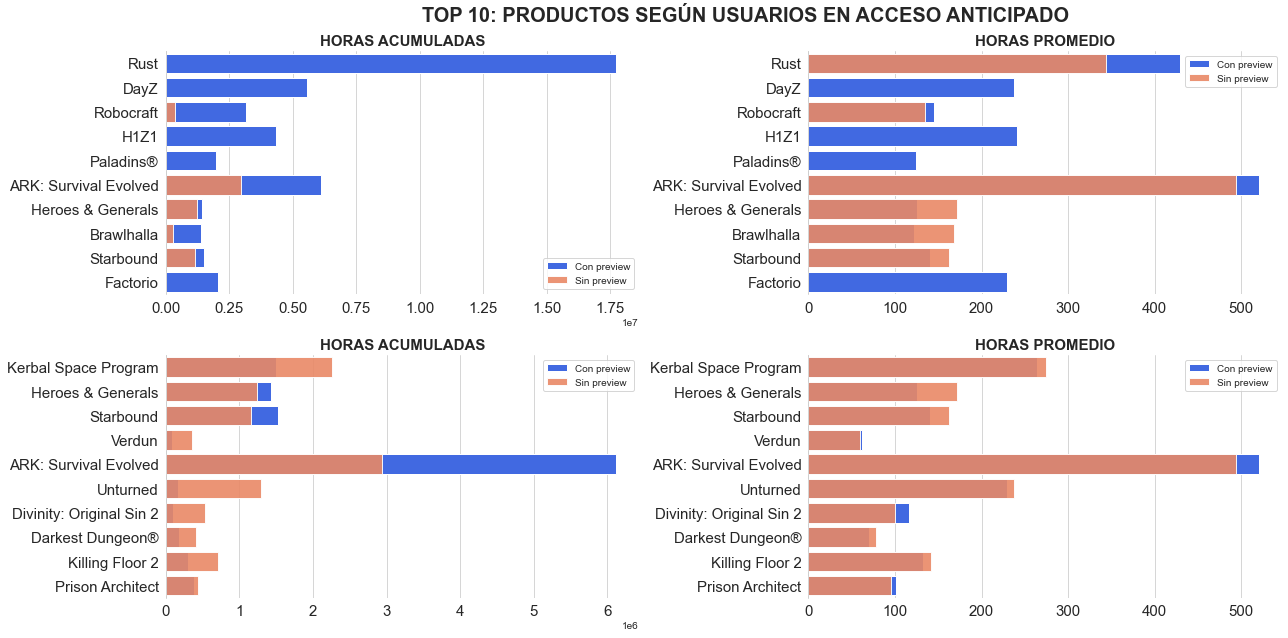

In [131]:
acumuladas = ['Acumuladas_WithPreview', 'Acumuladas_NoPreview', 'Horas acumuladas']
promedios = ['Promedio_WithPreview', 'Promedio_NoPreview', 'Horas promedio']

# Gráfica
fig, axs = plt.subplots(2, 2, figsize=(18,9), tight_layout=True)
fig.suptitle('Top 10: Productos según usuarios en acceso anticipado'.upper(), x=.58, fontsize=20, fontweight='bold')
for x in range(0,2):
    for y in range(0,2):     
        row = acumuladas if y < 1 else promedios
        idx = idx_true if x < 1 else idx_false
        my_data = plot.loc[idx].head(10)
        sns.barplot(y='Aplicación', x=row[0], data=my_data, color='Royalblue', label='Con preview', saturation=1, ax=axs[x][y])
        my_data = plot.loc[idx].head(10)
        sns.barplot(y='Aplicación', x=row[1], data=my_data, alpha=.9, color='Coral', label='Sin preview', ax=axs[x][y])
        axs[x][y].legend(fontsize=10)
        axs[x][y].set_title(f'{ row[2] }'.upper(), fontsize=15, fontweight='bold')
        axs[x][y].set_ylabel('')
        axs[x][y].set_xlabel('')
        axs[x][y].tick_params(labelsize=15)
sns.despine(bottom=True)        
plt.show()

Como se puede observar, existen juegos donde las horas acumuladas y el promedio de horas de los usuarios que no tuvieron acceso a la preview es mayor a la de usuarios que si optaron por acceder en las etapas previas de desarrollo; en el gráfico es posible distinguir la difencia que existe entre estos usuarios.

---
**TOP 10: Juegos con mayor promedio de horas**

---

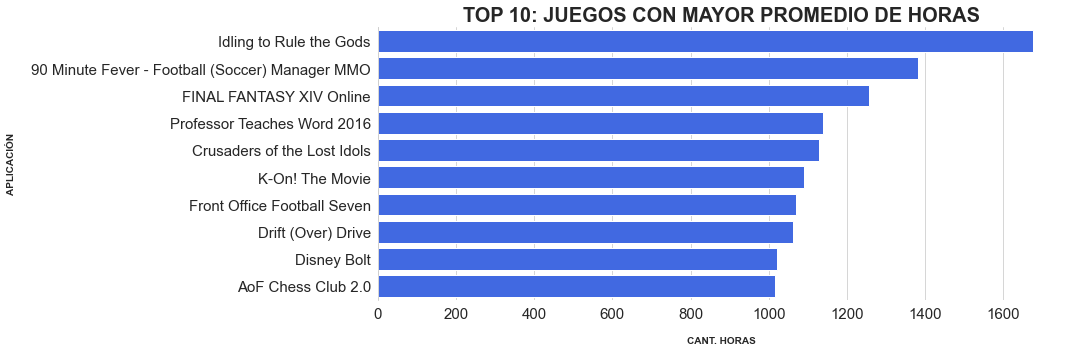

In [54]:
data = reviews_games.pivot_table(values=['Usuario', 'Cant. horas'], index=['GameID', 'Aplicación'],
                                 aggfunc={ 'Usuario': 'count', 'Cant. horas': 'mean' }).sort_values('Cant. horas', ascending=False)
data.reset_index(inplace=True)
data = data.head(10)

# Gráfica
plt.figure(figsize=(15,5), tight_layout=True)
sns.barplot(x='Cant. horas', y='Aplicación', data=data, color='Royalblue', saturation=1)
plt.title('TOP 10: Juegos con mayor promedio de horas'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Cant. horas'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Aplicación'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(bottom=True)
plt.show()

---
**Análisis de las horas respecto al TOP 10 de juegos con mayor promedio de horas**

---

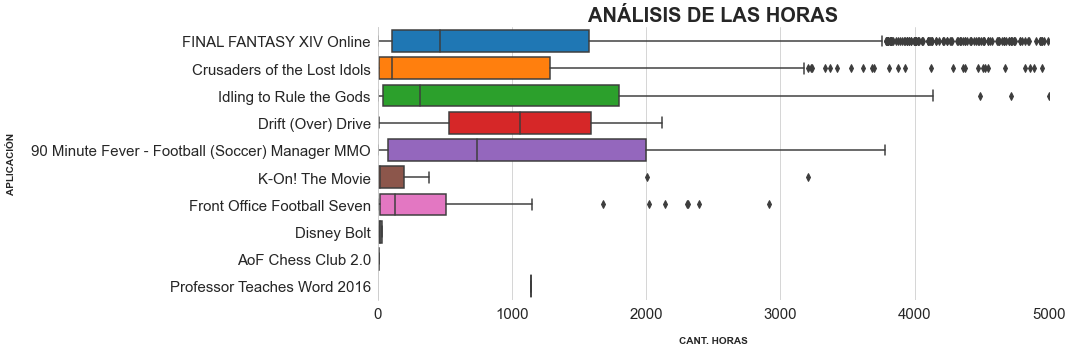

In [55]:
idx = data.GameID
mask = reviews_games['GameID'].isin(idx)

# Gráfica
plt.figure(figsize=(15,5), tight_layout=True)
sns.boxplot(y='Aplicación', x='Cant. horas', data=reviews_games[mask], saturation=1)
plt.title('Análisis de las horas'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Cant. horas'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.xlim(0,5000)
plt.ylabel('Aplicación'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(bottom=True)
plt.show()

In [62]:
comments = reviews_games.query('GameID in [ 447920, 340990, 385020 ]').loc[:,['Aplicación', 'Comentario']].sample(5).values

for app, comment in comments:
    print(f'{ app }'.upper())
    print(f'------------------------------')
    print(f'{ comment }')
    print(f'--------------------------------------------------')
    print(f'--------------------------------------------------\n')

DISNEY BOLT
------------------------------
Bolt is love. Bolt is life.
--------------------------------------------------
--------------------------------------------------

AOF CHESS CLUB 2.0
------------------------------
The music in the trailer reminds me of Ogre Battle.
--------------------------------------------------
--------------------------------------------------

AOF CHESS CLUB 2.0
------------------------------
What is wrong with the "Not Recommended" reviewers? The value of this game is that you can challenge any of the members or receive challemges from them. It is not compulsory to accept a challenge in just the same way as at a Chess Club. If your opponent does not respond to your first move then the game is dead and counted as invalid. If a player fails to respond within the three day limit then he loses. To shorten the three day limit could well mean that some players with heavy demands on their time woukl not compete and we should all be worse off.
I think this gam

Se puede observar que, mayoritariamente, existen reseñas negativas en estos juegos. Respecto al gráfico, hay que destacar, en relación al que corresponde a nuestro *TOP 10: Juegos con mayor promedio de horas*, que el juego con más comentarios no es el que tiene un promedio mayor de horas.

---
**TOP 10: Juegos con más comentarios discrimando el precio**

---

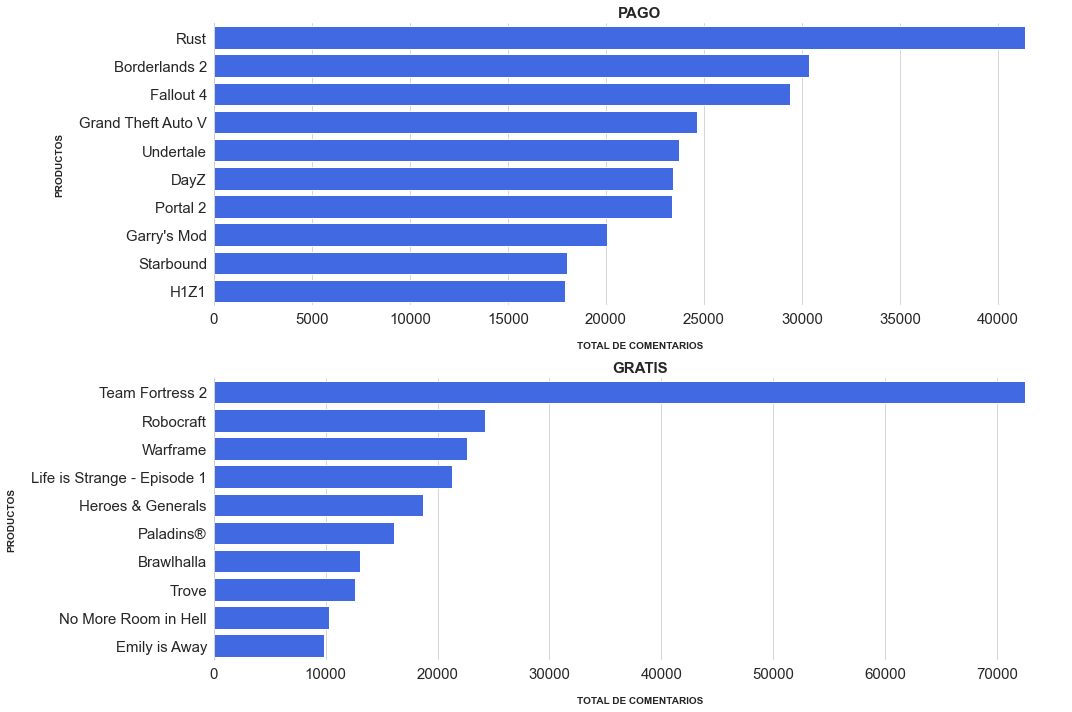

In [62]:
tipo_precio = ['Pago', 'Gratis']

# Gráfica
fig, axs = plt.subplots(2, 1, figsize=(15,10), tight_layout=True)
for x in range(0,2):
    precio = tipo_precio[x]
    data = reviews_games.query('Precio == @precio').groupby('Aplicación').agg(Usuarios=pd.NamedAgg(column='Usuario', aggfunc='count'))\
                                                                         .sort_values('Usuarios', ascending=False)
    data.reset_index(inplace=True)
    sns.barplot(x='Usuarios', y='Aplicación', data=data.head(10), color='Royalblue', saturation=1, ax=axs[x])
    axs[x].set_title(f'{ precio }'.upper(), fontsize=15, fontweight='bold')
    axs[x].tick_params(axis='both', labelsize=15)
    axs[x].set_xlabel('Total de comentarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].set_ylabel('Productos'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(bottom=True)
plt.show()

Analizamos como se comportan los usuario teniendo en cuenta el precio de los juegos y el acceso previo.

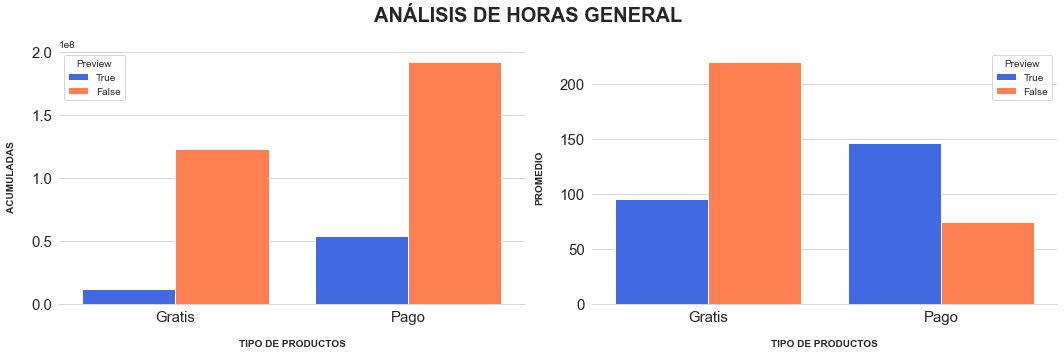

In [56]:
columns = ['Acumuladas', 'Promedio']
labels = { 'sum': 'Acumuladas', 'mean': 'Promedio' }
data = reviews_games.groupby(by=['Precio', 'Preview'])['Cant. horas'].agg(['sum', 'mean']).rename(columns=labels)
data.reset_index(inplace=True)

# Gráfica
fig, axs = plt.subplots(1, 2, figsize=(15,5), tight_layout=True)
fig.suptitle('Análisis de horas general'.upper(), fontsize=20, fontweight='bold')
for x in range(0,2):
    func = columns[x]
    sns.barplot(x='Precio', y=func, data=data.round(2), palette=['Royalblue', 'Coral'], hue='Preview', hue_order=[True, False], saturation=1,
                ax=axs[x])
    axs[x].tick_params(axis='both', labelsize=15)
    axs[x].set_ylabel(f'{func}'.upper(), fontsize=10, fontweight='bold', labelpad=15)
    axs[x].set_xlabel('Tipo de productos'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(left=True)
plt.show()

**CONCLUSIÓN**

---

Analizando las horas que invierten los usuarios utilizando los distintos productos podemos observar que, si bien, en nuestro dataset contamos con más del 80% de comentarios sobre artículos que cuestan dinero, el promedio de horas es menor. Haciendo un contraste con los usuarios que si accdedieron a versiones previas de los productos con aquellos que no lo hicieron, vemos como estos últimos tienen un promedio menor; no hay que olvidar que el porcentaje de usuarios que no ingresaron en etapas previas de desarrollo es superior al 80%, independientemente el precio del producto. No sería apresurado decir que estos usuarios puedan estar disconformes.

> Algo que debemos remarcar, *el promedio de horas de un usuario, con acceso previo a un determinado producto que no tiene costo, es similar al promedio de horas de un producto pago sin acceso previo*. Puede ser que esta similitud sea un indicio del tiempo que demora **un usuario en evaluar un producto**, pasado este tiempo, si el mismo no lo satisface, este producto pasa al olvido.

---
**Total de comentarios por año**

---

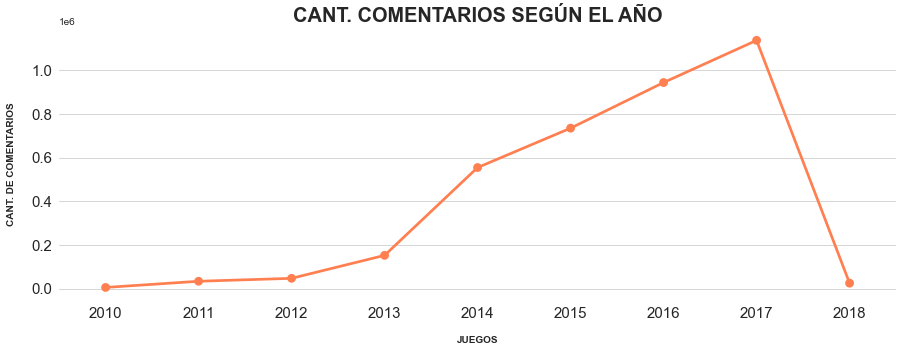

In [57]:
data = reviews_games.loc[:,['Usuario', 'Fecha', 'Comentario']]
data['Mes'] = data['Fecha'].dt.month_name()
data['Año'] = data['Fecha'].dt.year
group_year = data.groupby(by='Año').agg({'Comentario': 'count'})

# Gráfica
plt.figure(figsize=(15,5))
sns.pointplot(x=group_year.index, y='Comentario', data=group_year, color='Coral', saturation=1)
plt.title('Cant. comentarios según el año'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Juegos'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Cant. de comentarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
sns.despine(left=True, bottom=True)
plt.show()

La participación de los usuarios es lineal ascendente a medida que transcurre el tiempo, es nos marca como se fue afianzando la comunidad de steam participando en el foro.

---
**Mapa de calor para entender como se comportan los usuarios en el año discriminando los meses**

---

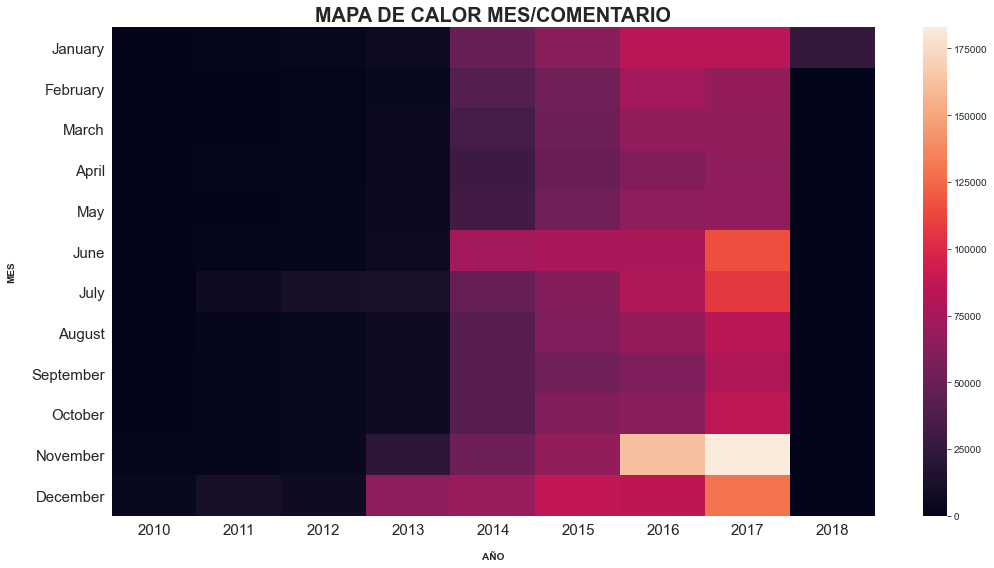

In [65]:
meses = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
data_dates = data.groupby('Año')['Mes'].value_counts().unstack().fillna(0)[meses].T

# Gráfica
plt.figure(figsize=(15,8), tight_layout=True)
plt.title('Mapa de calor mes/comentario'.upper(), fontsize=20, fontweight='bold')
sns.heatmap(data_dates)
plt.tick_params(labelsize=15)
plt.xlabel('Año'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.ylabel('Mes'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.show()

En este mapa de calor se puede observar como mes a mes aumenta la participación, en el foro, de forma gradual. En el año 2018 decae ya que no se recopilaron datos suficiente.

### Games

En esta sección continuamos el análisis exploratorio de los datos pero no centraremos en los datos referidos a los productos.

---
**Categorías que se encuentran en al menos el 5% de nuestros registros**

---

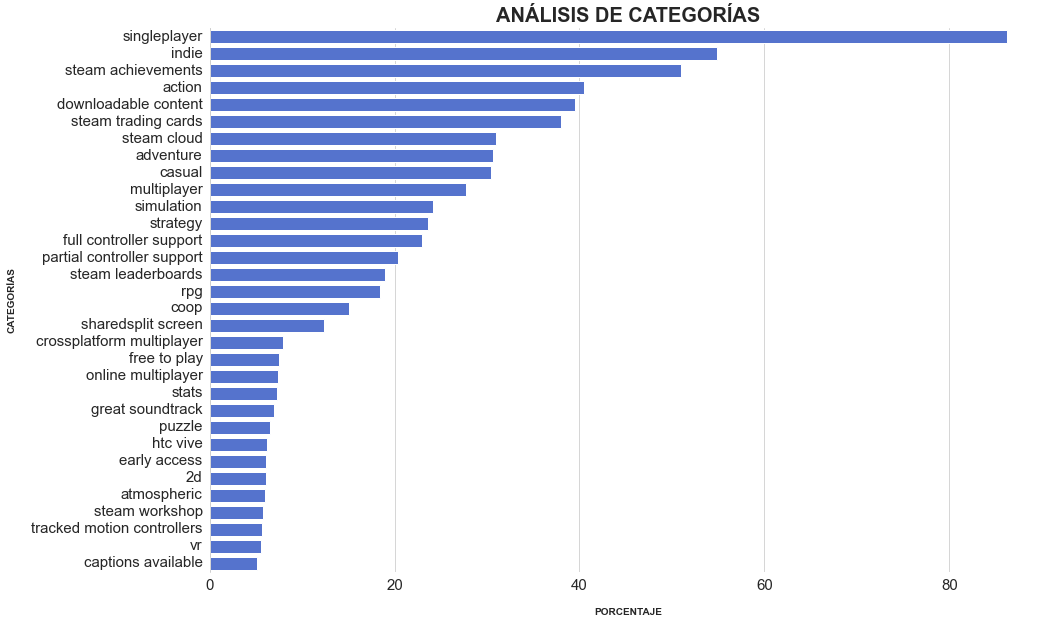

In [56]:
def one_dimension(series):
    return pd.Series([x for _list in series for x in _list], name='Categorías').value_counts()

data = one_dimension(games['Categorías']).apply(lambda x: x*100/len(games)).round(2)
mask = data.values > 5

# Gráfica
plt.figure(figsize=(15,10))
sns.barplot(y=data[mask].index, x=data[mask].values, color='Royalblue')
plt.tick_params(axis='both', labelsize=15)
plt.title('Análisis de categorías'.upper(), fontsize=20, fontweight='bold')
plt.xlabel('Porcentaje'.upper(), fontsize=10, labelpad=15, weight='bold')
plt.ylabel('Categorías'.upper(), fontsize=10, labelpad=15, weight='bold')
plt.yticks(va='center')
sns.despine(bottom=True)
plt.show()

Para mejorar nuestro modelo podemos realizar un tratamiento de outliers según la cant. de horas. También sería apropiado quitar aquellos juegos con pocas valoraciones por parte de los usuarios, podemos filtrar aquellos juegos que no llegan a un mínimo de 5 comentarios o una mínima cant. de horas acumuladas por los usuarios, etc. Esto lo hacemos para que nuestra matriz dispersa contenga mayor cantidad de datos en proporción a registros nulos.

## **Sistemas de recomendación**

### Benchmark

Como modelo benchmark, podemos recomendar los videojuegos de nuestro ***TOP 10: Juegos con más comentarios*** o ***TOP 10: Juegos con mayor cant. horas*** o ***TOP 10: Juegos con más comentarios***, también, podemos realizar ***TOP 10 de juegos discrimando el género*** o también realizar una sementación respecto al precio.

Existen ocasiones donde un nuevo juego o artículo se estrena y este mismo no posee calificaciones; a esta situación se la denomina ***COLD START***. En este caso, por medio de los metadatos que conseguimos del juego o artículo en cuestión, generamos proximidad a otros juegos/artículos. Este primer acercamiento, nos sirve para poder generar recomendaciones a través de la similitud de los metadatos que tienen nuestros productos.

---
FUNCIÓN PARA EXTRAER CORRELACIONES ENTRE LAS CATEGORÍAS

---

In [33]:
def categories_dataframe(item_lists, unique_items):
    bool_dict = {}    
    for i, item in enumerate(unique_items):
        bool_dict[item] = item_lists.apply(lambda x: item in x)

    return pd.DataFrame(bool_dict)

In [61]:
genres = np.unique(list(itertools.chain(*games['Categorías'])))
data = categories_dataframe(games['Categorías'], genres)
data = data.corr(method='pearson')

Con nuestras correlaciones calculadas, solo nos resta introducir algún metadato de nuestro juego que no tuvo puntuación y buscar que categorías tienen similitud al mismo y buscar un juego que las posea. Por ejemplo: buscamos un juego que sea *fps*.

In [72]:
data['fps'].sort_values(ascending=False).head(10)

fps            1.000000
shooter        0.510537
firstperson    0.506022
zombies        0.216116
action         0.206460
survival       0.200752
open world     0.200520
scifi          0.189294
teambased      0.186269
military       0.175079
Name: fps, dtype: float64

Las categorías que más se relacionan son shooter, firstperson, zombies, etc. Hacemos una búsqueda que nos devuelva los juegos con mayor cantidad de horas promedio que juegan los usuarios para realizar las recomendaciones.

In [77]:
cat = data['fps'].sort_values(ascending=False).head(10).index
idx = games.explode('Categorías').query('Categorías in @cat').GameID
reviews_games.query('GameID in @idx').pivot_table(index=['GameID', 'Aplicación'], values='Cant. horas',
                                                  aggfunc='mean').sort_values(by='Cant. horas', ascending=False).head(5)

,,Cant. horas
GameID,Aplicación,
39210,FINAL FANTASY XIV Online,1255.349487
402840,Crusaders of the Lost Idols,1129.241455
340990,Disney Bolt,1020.080017
47410,Stronghold Kingdoms,752.590149
440,Team Fortress 2,735.182739


De este modo, es un procedimiento muy burdo, obtenemos recomendaciones para un juego que se estreno recientemente y un usuario juega por primera vez. Inicialmente, no dista mucho de nuestros ranking basado en popularidad previos. 

Otra forma de proceder es generando valores dummies en nuestras categorías y luego filtrar aquellas nos pueden ser útiles.

In [105]:
mlb = MultiLabelBinarizer()
data = mlb.fit_transform(games['Categorías'])
dummy = pd.DataFrame(data, columns=mlb.classes_, index=games.GameID)

Visualizamos el shape de nuestra matriz

In [96]:
print(dummy.shape)
dummy.head()

(32122, 376)


,1980s,1990s,25d,2d,2d fighter,360 video,3d platformer,3d vision,4 player local,4x,...,warhammer 40k,web publishing,werewolves,western,windows mixed reality,word game,world war i,world war ii,wrestling,zombies
GameID,,,,,,,,,,,,,,,,,,,,,
761140,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
643980,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
670290,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
767400,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
773570,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Como se observa, tenemos 376 columnas que corresponden a nuestras categorías. Debemos hacer un filtrado para eliminar aquuellas que no proporcionan datos relevantes.

In [106]:
INVALID = ['1980s', '1990s', '25d', '2d fighter', '360 video', '3d platformer', '3d vision', '4 player local', '4x', '6dof',
           'alternate history', 'animation  modeling', 'animation amp modeling', 'arena shooter', 'artificial intelligence',
           'asynchronous multiplayer', 'audio production', 'base building', 'based on a novel', 'beat em up', 'benchmark',
           'bullet hell', 'bullet time', 'capitalism', 'captions available', 'cartoony', 'character action game',
           'character customization', 'choices matter', 'cinematic', 'city builder', 'classbased', 'clicker', 'cold war', 'colorful',
           'comic book', 'commentary available', 'controller', 'conversation', 'coop campaign', 'crowdfunded', 'cute', 'dark comedy',
           'dark fantasy', 'dark humor', 'dating sim', 'demons', 'design  illustration', 'design amp illustration', 'documentary',
           'downloadable content', 'dungeon crawler', 'dynamic narration', 'dystopian', 'early access', 'episodic', 'esports', 'faith',
           'family friendly', 'fastpaced', 'feature film', 'female protagonist', 'fmv', 'foreign', 'full controller support', 'game demo',
           'game development', 'gamemaker', 'gamepad', 'games workshop', 'gaming', 'god game', 'grand strategy', 'great soundtrack',
           'gridbased movement', 'gun customization', 'hack and slash', 'handdrawn', 'hardware', 'heist', 'hidden object', 'historical',
           'htc vive', 'hunting', 'illuminati', 'inapp purchases', 'includes level editor', 'includes source sdk',
           'intentionally awkward controls', 'interactive fiction', 'inventory management', 'isometric', 'keyboard  mouse', 'lara croft',
           'lego', 'lemmings', 'level editor', 'linear', 'local coop', 'local multiplayer', 'loot', 'lorerich', 'lovecraftian',
           'mars', 'match 3', 'mature', 'mechs', 'memes', 'metroidvania', 'military', 'mini golf', 'moddable', 'modern', 'mods',
           'mods require hl1', 'mods require hl2', 'mouse only', 'movie', 'multiple endings', 'music', 'musicbased procedural generation',
           'mystery dungeon', 'narration', 'nonlinear', 'oculus rift', 'offroad', 'online coop', 'onrails shooter', 'open world',
           'otome', 'parkour', 'parody', 'partial controller support', 'partybased rpg', 'perma death', 'photo editing', 'pixel graphics',
           'platformer', 'point  click', 'political', 'politics', 'pool', 'postapocalyptic', 'procedural generation', 'programming',
           'puzzleplatformer', 'quicktime events', 'real time tactics', 'realtime', 'realtime with pause', 'relaxing', 'remake', 
           'replay value', 'resource management', 'rhythm', 'roguelike', 'roguelite', 'romance', 'rome', 'roomscale', 'rpgmaker', 'rts',
           'sandbox', 'satire', 'score attack', 'seated', 'sexual content', 'sharedsplit screen', 'shoot em up', 'short', 'side scroller',
           'silent protagonist', 'simulation', 'software', 'software training', 'soundtrack', 'space sim', 'spectacle fighter',
           'spelling', 'split screen', 'standing', 'star wars', 'stats', 'steam achievements', 'steam cloud', 'steam leaderboards',
           'steam machine', 'steam trading cards', 'steam turn notifications', 'steam workshop', 'steamvr collectibles', 'story rich',
           'stylized', 'superhero', 'supernatural', 'surreal', 'swordplay', 'tactical rpg', 'tanks', 'teambased', 'textbased',
           'time attack', 'time manipulation', 'time travel', 'topdown', 'topdown shooter', 'touchfriendly', 'tracked motion controllers',
           'trackir', 'trading card game', 'trains', 'transhumanism', 'turnbased', 'turnbased combat', 'turnbased strategy',
           'turnbased tactics', 'tutorial', 'twin stick shooter', 'typing', 'underwater', 'utilities', 'valve anticheat enabled',
           'vampire', 'video production', 'villain protagonist', 'visual novel', 'voice control', 'voxel', 'vr', 'walking simulator',
           'warhammer 40k', 'web publishing', 'werewolves', 'windows mixed reality', 'word game', 'world war i', 'world war ii','zombies']
dummy.drop(columns=INVALID, inplace=True)
dummy.shape

(32122, 138)

Generamos nuestra matriz de distancias utilizando la similitud del coseno.

In [ ]:
del similitudes
similitudes = cosine_similarity(dummy, dense_output=True)
similitudes.shape

(32122, 32122)

Creamos una función que nos imprima las recomendaciones basadas en la similitud de coseno.

In [213]:
index = pd.Series(games['GameID'])
def recomendations(gameID, simil=similitudes):
    top = []
    idx = index[index == gameID].index[0]
    scores = pd.Series(simil[idx]).sort_values(ascending=False)
    for idx, score in zip(scores.iloc[1:11].index, scores.iloc[1:11].values):
        app = games.loc[idx, 'Aplicación']
        print(f'{ app }: { score.round(2) }')
        top.append((app, score))

Generamos recomendaciones para distintos productos.

In [215]:
# FINAL FANTASY XIV Online
recomendations(39210)

FINAL FANTASY XIV Online Starter Edition: 1.0
The Elder Scrolls® Online: Tamriel Unlimited™: 0.79
Tree of Savior (English Ver.): 0.78
DRAGON QUEST HEROES™ II: 0.77
Minimon: 0.77
Ragnarok Online 2: 0.77
FINAL FANTASY XIV Online Free Trial: 0.77
AdventureQuest 3D: 0.76
Mabinogi: 0.75
MapleStory: 0.75


In [214]:
# Team Fortress 2
recomendations(440)

The Ultimatest Battle: 0.69
Double Action: Boogaloo: 0.65
Ace of Spades: Battle Builder: 0.65
Tom Clancy's Rainbow Six® Siege - Ultra HD Texture Pack: 0.63
Nuclear Dawn: 0.63
HIT: 0.62
Synergy: 0.62
HTC Vive: 0.62
Blue Estate The Game: 0.62
ShootMania Storm: 0.61


En estos dos acercamientos a un sistema de recomendación no tenemos en cuenta ningún tipo de datos proveniente de los usuarios. Únicamente nos basamos en el contenido y los metadatos que podemos extraer de las categorías.

### Sistema de recomendación: Basado en contenido

Implementamos un motor de recomendación utilizando un filtro basado en contenido. Hacemos uso de la librería `Implicit`, la cuál, nos ayuda en una problemática que se puede ver a lo largo de todo nuestro análisis: carecemos de un puntaje explícito por parte de los usuarios.

#### Implicit ratings

De acuerdo al análisis de nuestros datos, corroboramos la ausencia de un rating o feedback explícito en formato número por parte de los usuarios. Contamos con dos aproximaciones para extraer la opinión de los usuarios: *un feedback escrito* y un atributo donde *el usuario califica que tan divertido es un juego*, este no nos puede ayudar porque tiene mucha presencia de valores nulos. Para procesar los comentarios, nuestro feedback escrito, debemos usar técnicas de procesamiento de lenguajes naturales la cuál vamos a profundizar en el proyecto final, por otro lado, la puntuación por parte de los usuarios fue una columna que se eliminó en la elección de columnas debido a la alta presencia de valores faltanes, más del 80% de los registros estaban afectados.

Nuestra variable que nos va a ayudar a predecir las recomendaciones es el atributo `Cant. horas`, como vimos en el análisis exploratorio de datos. Realizamos un escalado de dicho atributo.

In [33]:
horas = reviews_games['Cant. horas'].values
scale = RobustScaler().fit_transform(horas.reshape(-1,1))
reviews_games['Hours scale'] = scale

Generamos datos únicos categóricos con el objetivo de generar un identificador único para nuestros atributos `Usuario`.

In [56]:
users = pd.DataFrame(reviews_games['Usuario'].unique(), columns=['Usuario'])
users['UsuarioID'] = users['Usuario'].astype('category').cat.codes

print(len(users['Usuario'].unique()))
print(len(users['UsuarioID'].unique()))
assert(len(users['Usuario'].unique()) == len(users['UsuarioID'].unique()))
users.head()

1708420
1708420


,Usuario,UsuarioID
0,No Man's Sky,752888
1,Ori,780062
2,mhputnam27,1465905
3,Pink Panther,812154
4,⚡ SCARLETT SPEEDSTER ⚡,1678389


Elegimos las columnas más relevantes de nuestro dataset.

In [57]:
rs_data = reviews_games[['Usuario', 'Cant. horas', 'GameID', 'Aplicación']].merge(users, how='left', on='Usuario')
rs_data = rs_data.reindex(columns=['UsuarioID', 'Usuario', 'Cant. horas', 'GameID', 'Aplicación'])
rs_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3634562 entries, 0 to 3634561
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   UsuarioID    int32  
 1   Usuario      string 
 2   Cant. horas  float32
 3   GameID       int32  
 4   Aplicación   string 
dtypes: float32(1), int32(2), string(2)
memory usage: 124.8 MB


Tomamos 1.000.000 de registros para evitar problemas en el procesamiento de nuestros datos para generar nuestras matrices dispersas.

In [36]:
samples = sample_without_replacement(method='auto', n_population=rs_data.shape[0], n_samples=1000000, random_state=10)
data = rs_data.loc[samples,:]
print(data.shape)
data.head()

(1000000, 5)


,UsuarioID,Usuario,Cant. horas,GameID,Aplicación
1825188,816190,Player_7,7.100000,427270,Orcs Must Die! Unchained
1353044,1123474,ValiantPhantom,14.800000,374320,DARK SOULS™ III
2321105,136479,Bkiller,3.700000,398710,Timberman
438110,182172,Cappuccino.to.go,7.900000,591740,Sniper Fury
1811697,1261041,basedtater,64.400002,316010,Magic Duels


Antes de proseguir, verificamos la proporción de datos nulos que podemos encontrarnos en nuestra matriz dispersa.

In [87]:
proportion = float(data.shape[0])/float(len(data.GameID.unique())*len(data.UsuarioID.unique())) * 100
print(f'Proporción de valores nulos: { round(proportion, 4) }%')

Proporción de valores nulos: 0.0118%


Como se observa, solo el 0.01% de datos están presentes en nuestra matriz dispersa. Esto nos está indicando la escasa cantidad de reseñas que los juegos tienen por los usuarios. Recordando, tenemos un **total de 1.716.724 usuarios** los cuáles, comentario un **total de 14.970 productos/juegos**.

In [37]:
sparse_item_user = sparse.csr_matrix((data['Cant. horas'], (data['GameID'], data['UsuarioID'])))

Instanciamos un modelo ALS.

In [38]:
alpha = 50
train, test = evaluation.train_test_split(sparse_item_user*alpha, train_percentage=.66)
als = AlternatingLeastSquares(factors=40, iterations=25, random_state=5, regularization=.1)
als.fit(train)

  0%|          | 0/25 [00:00<?, ?it/s]

Evaluamos nuestro modelo con la métrica **NDCG**. El motivo de elección es conseguir evalúar la relevancia de los productos en nuestro ranking, los productos muy relevantes deben ir antes que los que posean relevancia media, que deben ir antes que los no relevantes.

In [39]:
ndcg = evaluation.ndcg_at_k(als, train, test, 5)
print(f'Normalized discounted cumulative gain: { ndcg }')

  0%|          | 0/775461 [00:00<?, ?it/s]

Normalized discounted cumulative gain: 1.4275640133180849e-05


Obtenemos un valor de **NDCG muy cercano a 0**. Este valor nos da la pauta que nuestro modelo está realizando predicciones sin sustento en los datos.
Creamos una función para obtener las recomendaciones utilizando el algoritmo ALS.

In [87]:
def recomendaciones(usuario, model):
    #user_items = sparse_user_item.T.tocsr()
    user_items = sparse_item_user.T.tocsr()
    model = model.recommend(usuario, user_items, 10)
    idx, scr = ([recomendation[0] for recomendation in model], [recomendation[1] for recomendation in model])
    #scr = [recomendation[1] for recomendation in model]
    apps = games.query('GameID == @idx').Aplicación
    print(pd.DataFrame(scr, index=apps, columns=['Score']))

Hacemos pruebas con diferentes usuarios.

In [59]:
# STV
recomendaciones(903371, als)

                                              Score
Aplicación                                         
Hotline Miami                              0.853796
Five Nights at Freddy's 4                  0.804958
Stick Fight: The Game                      0.779223
Overgrowth                                 0.769528
Dead Realm                                 0.751882
The Beginner's Guide                       0.738895
Batman™: Arkham Knight                     0.729109
Game of Thrones - A Telltale Games Series  0.716732
Stronghold 3 Gold                          0.701874
Legend of Grimrock                         0.693711


In [52]:
# dumbcunt
recomendaciones(1330197, als)

                     Score
Aplicación                
APB Reloaded      1.124539
Undertale         0.633725
Who's Your Daddy  0.627422
Squad             0.611467
DARK SOULS™ II    0.592182
Far Cry 3         0.567410
PlanetSide 2      0.523703
Borderlands 2     0.517705
F.E.A.R.          0.503339
Team Fortress 2   0.490666


In [53]:
# Cole Mooneyes
recomendaciones(215179, als)

                                                  Score
Aplicación                                             
Mount & Blade: Warband                         0.712494
Portal 2                                       0.609683
Hero Siege                                     0.598087
The Binding of Isaac: Rebirth                  0.569249
Mad Max                                        0.558453
Prison Architect                               0.553724
Just Cause™ 3                                  0.553168
Heroes & Generals                              0.549592
Battlerite                                     0.549188
The Elder Scrolls® Online: Tamriel Unlimited™  0.543353


Para mejorar el rendimiento de nuestro modelo, debemos realizar un filtrado de nuestros datos para poder realizar mejores recomendaciones. Podemos lograr esto buscando valores mínimos necesarios que debería tener, o bien, un producto, o bien, un usuario.

Por ejemplo, analizamos el total de comentarios que un videojuego posee.

In [73]:
final_data = rs_data.copy()

---
**Cant. de comentarios según productosfinal_data**

---

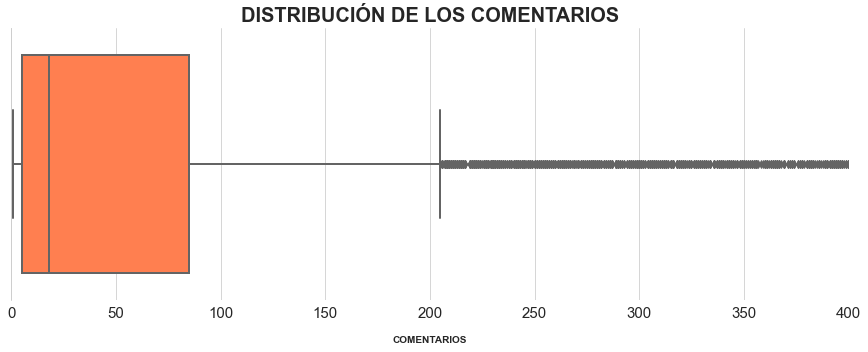

In [74]:
comentarios = final_data.groupby('GameID').agg(TotalComentarios=pd.NamedAgg(column='UsuarioID', aggfunc='count'))

# Gráfica
plt.figure(figsize=(15,5))
sns.boxplot(x='TotalComentarios', data=comentarios, color='Coral', linewidth=2, saturation=1)
plt.title('Distribución de los comentarios'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Comentarios'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.xlim(0,400)
sns.despine(bottom=True)
plt.show()

Como se puede observar, el primer cuartil está situado en cinco comentarios, la mediana de nuestros datos es menor a 25 comentarios y el tercer cuartil es superior a 75 comentarios. Con estos datos, podemos crear un filtro para eliminar aquellos registros que no cumplan los requisitos necesarios.

Establecemos un mínimo de 5 comentarios por los usuarios para que puedan ingresar a nuestro sistema de recomendación.

In [75]:
arafue = comentarios.query('TotalComentarios < 10').shape[0]
print(f'{ arafue } productos quedan por fuera de nuestro filtro.')

5577 productos quedan por fuera de nuestro filtro.


Me parece apropiado establecer una segmentación poniendo en foco en el total de comentarios que posee y no las horas acumuladas ya que buscamos heterogeneidad respecto a las valoraciones de los usuarios.

Procedemos a filtrar estos juegos.

In [76]:
products = comentarios.query('TotalComentarios < 10').index
final_data = final_data.query('GameID not in @products')

Para con los usuarios procedemos de similar forma, podemos tener en cuenta la cantidad de horas que juegan a los productos, el total de productos que comentan, etc.

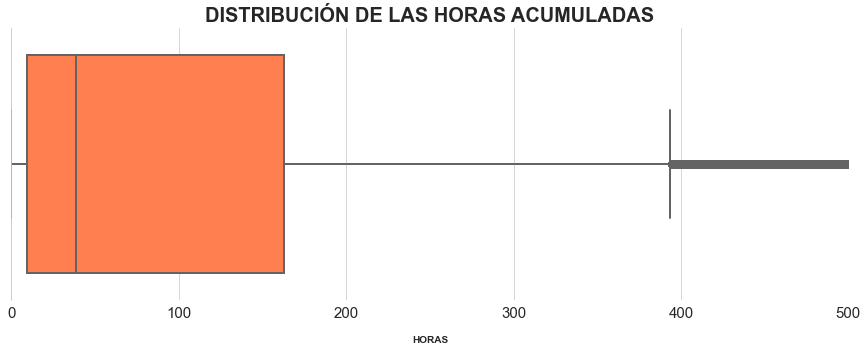

In [77]:
horas = final_data.groupby('UsuarioID').agg(Promedio=pd.NamedAgg(column='Cant. horas', aggfunc='sum'))

# Gráfica
plt.figure(figsize=(15,5))
sns.boxplot(x='Promedio', data=horas, color='Coral', linewidth=2, saturation=1)
plt.title('Distribución de las horas acumuladas'.upper(), fontsize=20, fontweight='bold')
plt.tick_params(labelsize=15)
plt.xlabel('Horas'.upper(), fontsize=10, fontweight='bold', labelpad=15)
plt.xlim(0,500)
sns.despine(bottom=True)
plt.show()

En la distribución de las horas, podemos observar que la mediana es cercana a un día; establecemos nuestro filtro de un día, por lo tanto, un usuario, debe acumular 24 horas para que sea tomado en cuenta.

In [78]:
arafue = horas.query('Promedio < 24').shape[0]
print(f'{ arafue } usuarios quedan por fuera de nuestro filtro.')

701029 usuarios quedan por fuera de nuestro filtro.


La idea de establecer dicho límite es tomar las valoraciones de aquellos usuarios que son activos en la plataforma.

In [79]:
users = horas.query('Promedio < 24').index
final_data = final_data.query('UsuarioID not in @users')

Corroboramos nuevamente la proporción de valores faltantes

In [81]:
final_data.reset_index(drop=True, inplace=True)
proportion = float(final_data.shape[0])/float(len(final_data.GameID.unique())*len(final_data.UsuarioID.unique())) * 100
print(f'Proporción de valores nulos: { round(proportion, 4) }%')

Proporción de valores nulos: 0.0296%


Vemos una leve mejora, de todas maneras, se debe tener en cuenta que no llegamos al 0.1% de datos. Evaluamos nuestro modelo y verificamos el rendimiento

In [85]:
sparse_item_user = sparse.csr_matrix((final_data['Cant. horas'], (final_data['GameID'], final_data['UsuarioID'])))

alpha = 30
train, test = evaluation.train_test_split(sparse_item_user*alpha, train_percentage=.66)
als = AlternatingLeastSquares(factors=70, iterations=20, random_state=5, regularization=.1)
als.fit(train)

  0%|          | 0/20 [00:00<?, ?it/s]

In [86]:
ndcg = evaluation.ndcg_at_k(als, train, test, 5)
print(f'Normalized discounted cumulative gain: { ndcg }')

  0%|          | 0/772541 [00:00<?, ?it/s]

Normalized discounted cumulative gain: 0.00018438051607165047


In [88]:
# STV
recomendaciones(903371, als)

                                            Score
Aplicación                                       
Tropico 4                                0.645650
PAC-MAN™ Championship Edition DX+        0.589603
MASSIVE CHALICE                          0.546575
Duck Game                                0.521246
Rebuild 3: Gangs of Deadsville           0.490827
Legend of Grimrock 2                     0.486475
Ryse: Son of Rome                        0.482013
Gods Will Be Watching                    0.476518
THE KING OF FIGHTERS XIII STEAM EDITION  0.475749
Just Cause 2                             0.473953


Conclusión:
---    

Luego de pasar por este proyecto encuentro un crecimiento personal debido a la dificultad que plantea el análisis y procesamiento de datos no estructurados. La magnitud de datos presentes fueron un desafío desde el primer momento, cualquier error al momento de crear consultas/escribir código se penalizaba con tiempo de procesamiento, de una sesión de trabajo de 5 h únicamente 2 h fueron productivas para avanzar en el proyecto.

En todo el trabajo realizado no hay que olvidar que se dejaron fuera de análisis el 50% de nuestras críticas. En parte fue por el procesamiento, en parte por como encontrar un flujo de trabajo para analizarlos. Siento que en la etapa de procesamiento quedaron muchas aristas por explorar, usar técnicas de nlp para conseguir una mejor representación de la valoración por parte de los usuarios es algo que estuvo el presente desde el primer momento. A su vez, no terminar de comprender correctamente el atributo `Cant. productos` es algo que me inquieta ya que investigando diversos proyectos por Kaggle, se podría haber barajado crear una valoración por los usuarios.

El dataset que corresponde a los productos fue el que por escandalo el que presentó batalla al momento de ejecutar código por primera vez. Tener listas en los campos fue algo con que lidiar en todo momento. Conseguir extraer información de allí, como a su vez, realizar segmentaciones en dicho dataset fue una locura que implicó horas de trabajo. No se terminó de extraer todo el jugo ya que investigando trabajos relacionados con dicho dataset se pudo verificar que existen más de 600 paquetes descargables.

Finalmente, lidiar con un rating implícito puede implicar varios caminos por elegir, se tomó continuar aquel que en la comunidad primar, entrenar e implementar un modelo mínimos cuadrados alternos. Como se observa, nuestra métrica marginalmente tuvo una mejora, de todas maneras, queda muchisimo trabajo por recorrer para llegar a algo que pueda ser utilizado en producción.

Como autocrítica puedo entender que el tiempo de demora en entregar el proyecto esta directamente relacionado con la comprensión del mismo *—algo lerdo si se quiere—*. Por otra parte, no terminar de explorar todas las técnicas conocidas para poder extraer un mejor rendimiento en nuestro modelo es algo pendiente a futuro.